# "Save The Expanse" Twitter Campaign Analysis
Hashtags included (case-insensitive):
- #TheExpanse
- #SaveTheExpanse
- #RenewTheExpanse
- #WatchExpanseLive
- #KeepTheRociFlying
- #ScreamingFirehawks
- #CantStopTheWork
- #RememberTheCant

In [63]:
import re
import string
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from matplotlib import rcParams

# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = 'times new roman'
sns.set(style='whitegrid', context='poster')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Import data

In [64]:
data_dir = '../data/'
csv_names = [
    'the-expanse-clean.csv',
    'save-the-expanse-clean.csv',
    'renew-the-expanse-clean.csv',
    'watch-expanse-live-clean.csv',
    'keep-the-roci-flying-clean.csv',
    'screaming-firehawks-clean.csv',
    'cant-stop-the-work-clean.csv',
    'remember-the-cant-clean.csv',
]

df_map = dict()
for csv_name in csv_names:
    csv_path = os.path.join(data_dir, csv_name)
    key = csv_name[:-10]
    df_map[key] = pd.read_csv(csv_path)

# Combine data and dedupe

In [65]:
df = pd.concat(df_map.values(), axis='rows')
df = df.drop_duplicates(subset=['user', 'text'], keep='first')
df.sample(20).text

4745                        @AmazonStudios #SaveTheExpanse
29224    #BelterPower #SaveTheExpanse #RenewTheExpansep...
16051    Before you go doing something you'll regret fo...
30478       #TheExpanse #SaveTheExpanse #KeepTheRociFlying
4713     D'après @TechCrunch the expansé aura une 4eme ...
493      #SaveTheExpanse / #RenewTheExpanse https://twi...
33827    Damn! Every time I like show, it gets canceled...
27997    As glad as I am to see Errinwright go down uh,...
3215     #RenewTheExpanse #SaveTheExpanse the best gosh...
4856     My first tweet since 2012 tells you how much I...
4333     @Amazon makes it official: #TheExpanse will ge...
11851    Holy shit! Just got chills watching the previe...
31372    Guys, listen to your pilot! Only 2 tweets per ...
6453     Family checker-in-onner. #SaveTheExpanse #High...
4547     Well we aren't on Thycho #TheExpanse #Afterbuz...
39995    Couldn’t agree more. #TheExpanse is absolutely...
10151                              Into #TheExpanse we g

# Clean data

In [66]:
# Remove records with 'NaN' timestamps
df = df[df['timestamp'].notnull()]

# Convert timestamps to datetime objects and sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by = 'timestamp')

# Timestamps are in mountain time. Convert to EST.
df['timestamp'] = df['timestamp'] + pd.Timedelta(hours=2)
df = df.set_index('timestamp')

# Limit date range to may
df = df[df.index.month == 5]

# Basic Info

In [67]:
print('Hashtag: all STE hashtags')

start_date = str(min(df.index).date())
end_date = str(max(df.index).date())
print(f'Date range: {start_date} to {end_date}')

num_uniq_tweets = df['text'].nunique()
print(f'Number of unique tweets: {num_uniq_tweets}')

num_tot_tweets = df['retweets'].sum() + num_uniq_tweets
print(f'Number of tweets and retweets: {int(num_tot_tweets)}')

num_uniq_users = df['user'].nunique()
print(f'Number of unique users who wrote original tweets: {num_uniq_users}')

Hashtag: all STE hashtags
Date range: 2018-05-08 to 2018-05-31
Number of unique tweets: 87121
Number of tweets and retweets: 327800
Number of unique users who wrote original tweets: 19913


# Most prolific tweeters

Text(0.5,1,'Most prolific tweeters')

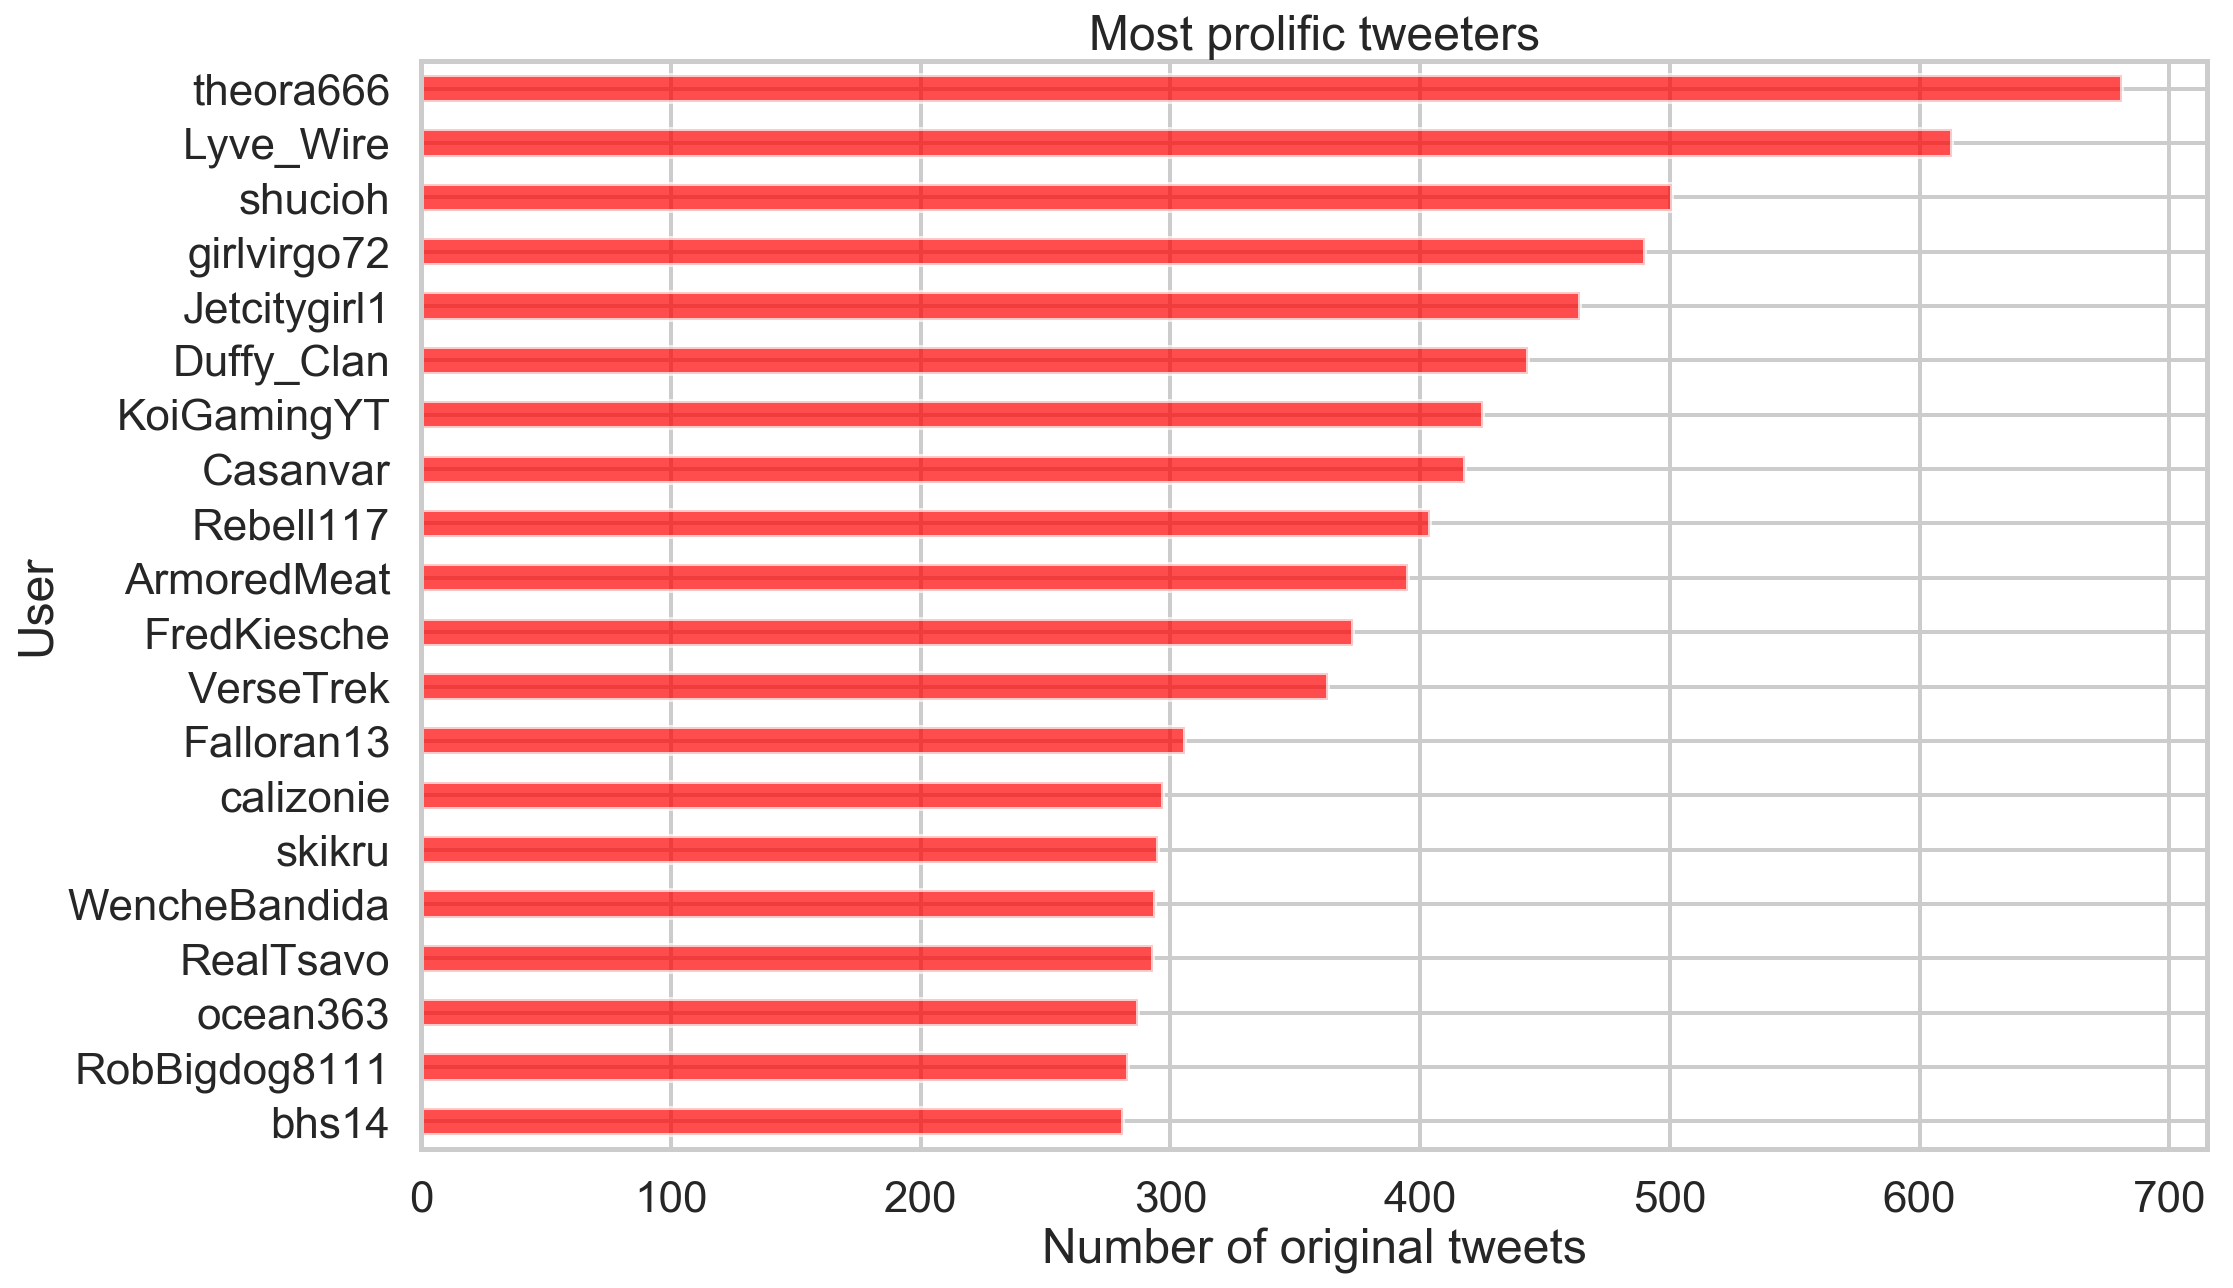

In [86]:
# Remove paraguy99 who might as well have been a bot
most_prolific = df[df['user'] != 'paraguy99']

most_prolific = most_prolific['user'].value_counts().head(20)
most_prolific = most_prolific.sort_values(ascending=True)
ax = most_prolific.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16,10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of original tweets')
ax.set_title('Most prolific tweeters')

# Most influential tweeters (by retweets)

Text(0.5,1,'Most influential tweeters')

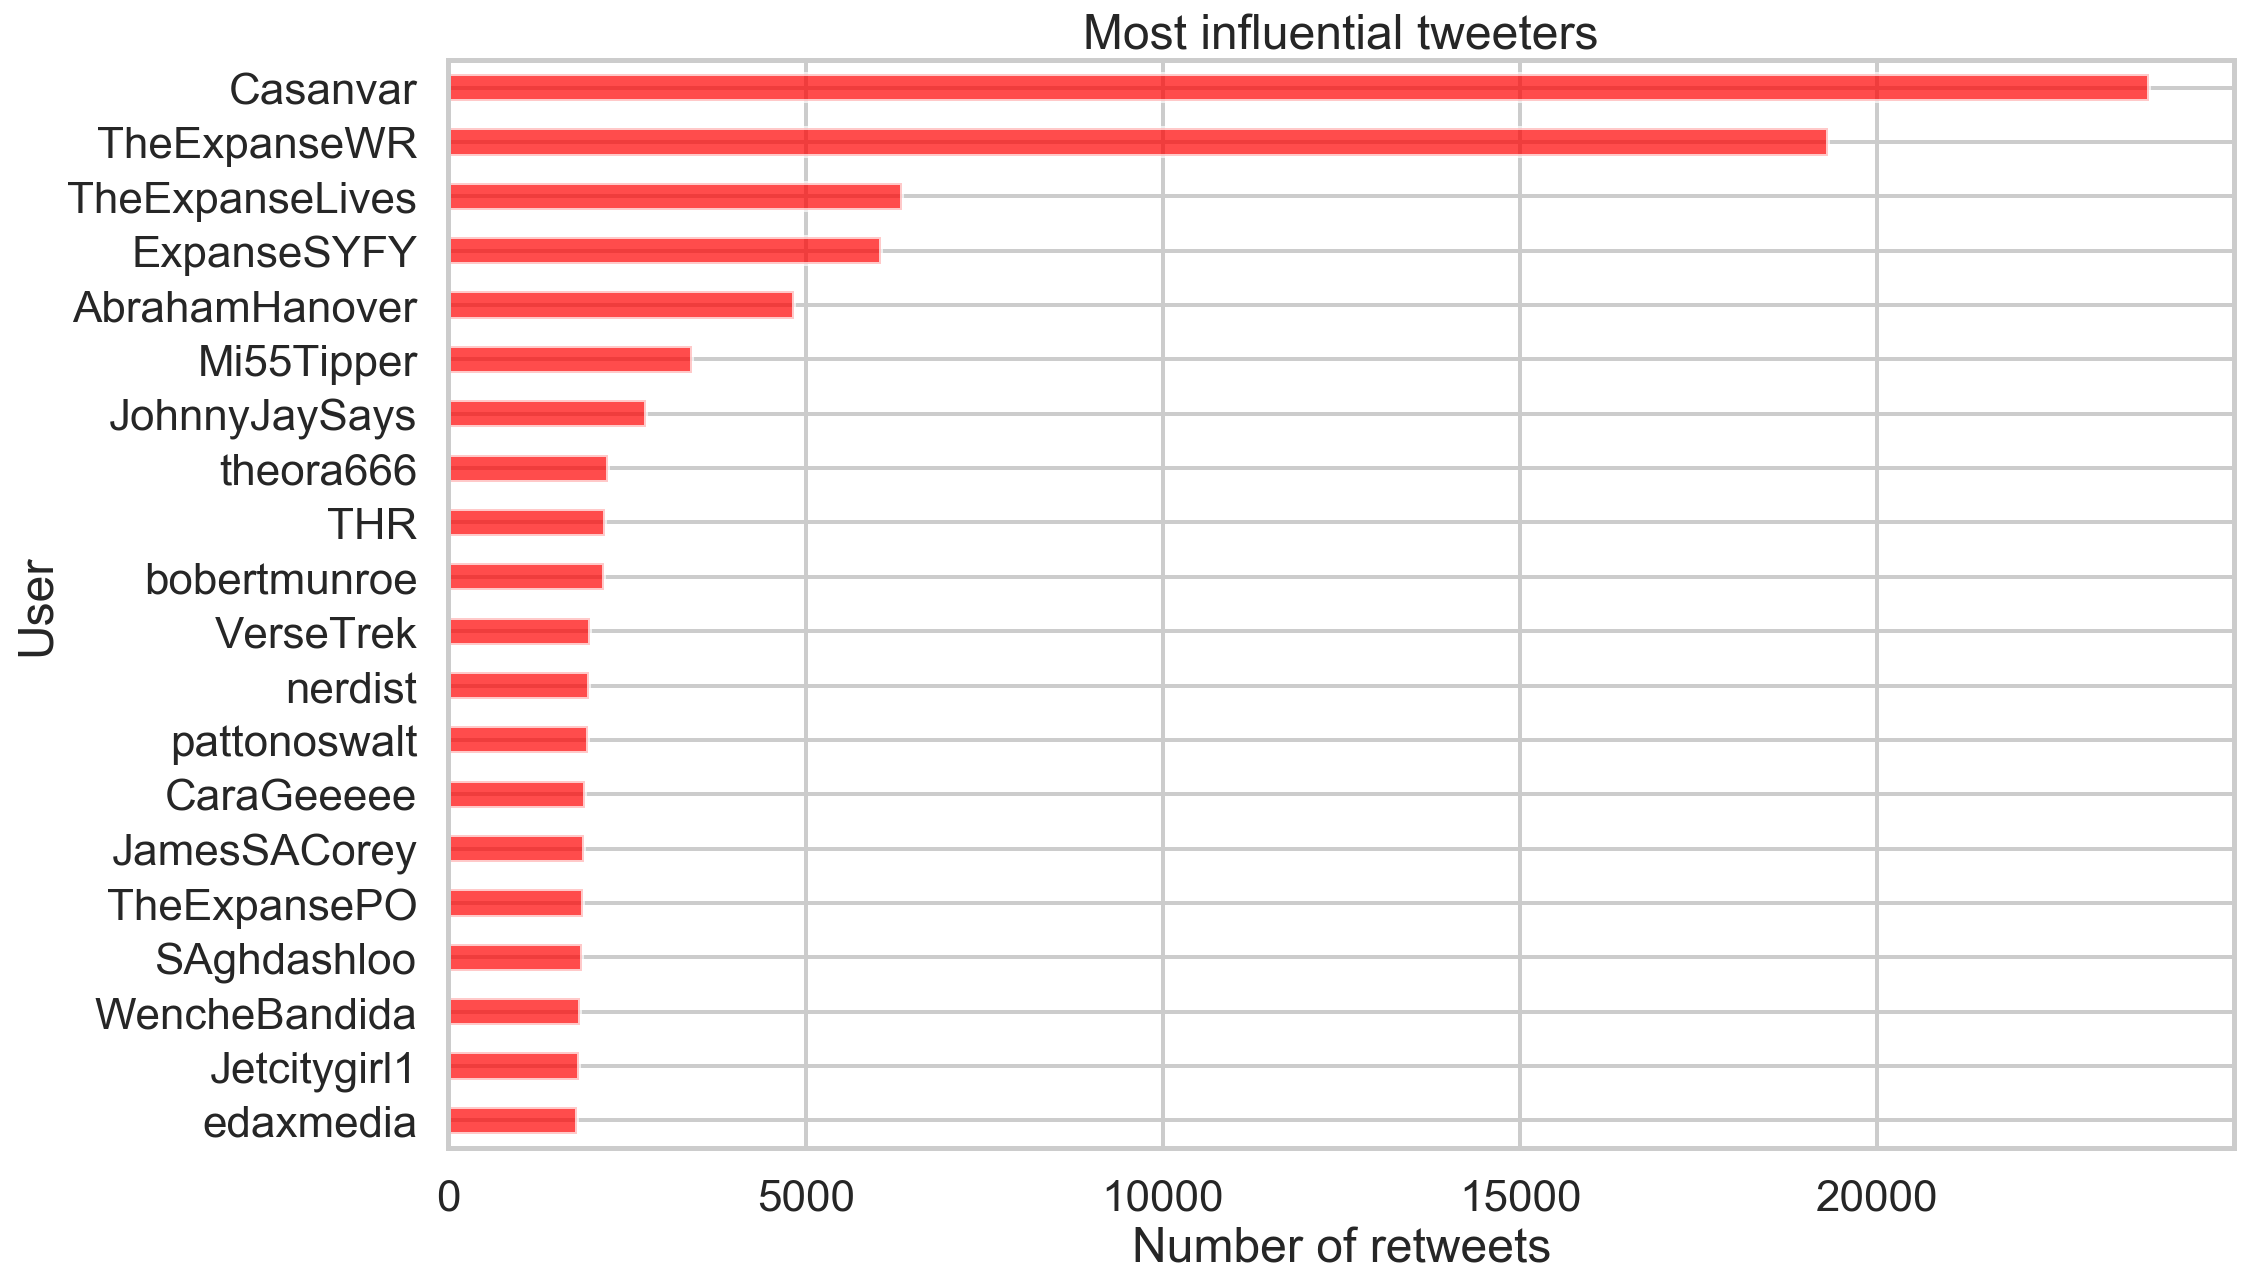

In [69]:
most_influential = df.groupby('user')['retweets'].sum().sort_values().tail(20)
ax = most_influential.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16, 10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of retweets')
ax.set_title('Most influential tweeters')

# Most influential tweeters (by likes)

Text(0.5,1,'Most liked tweeters')

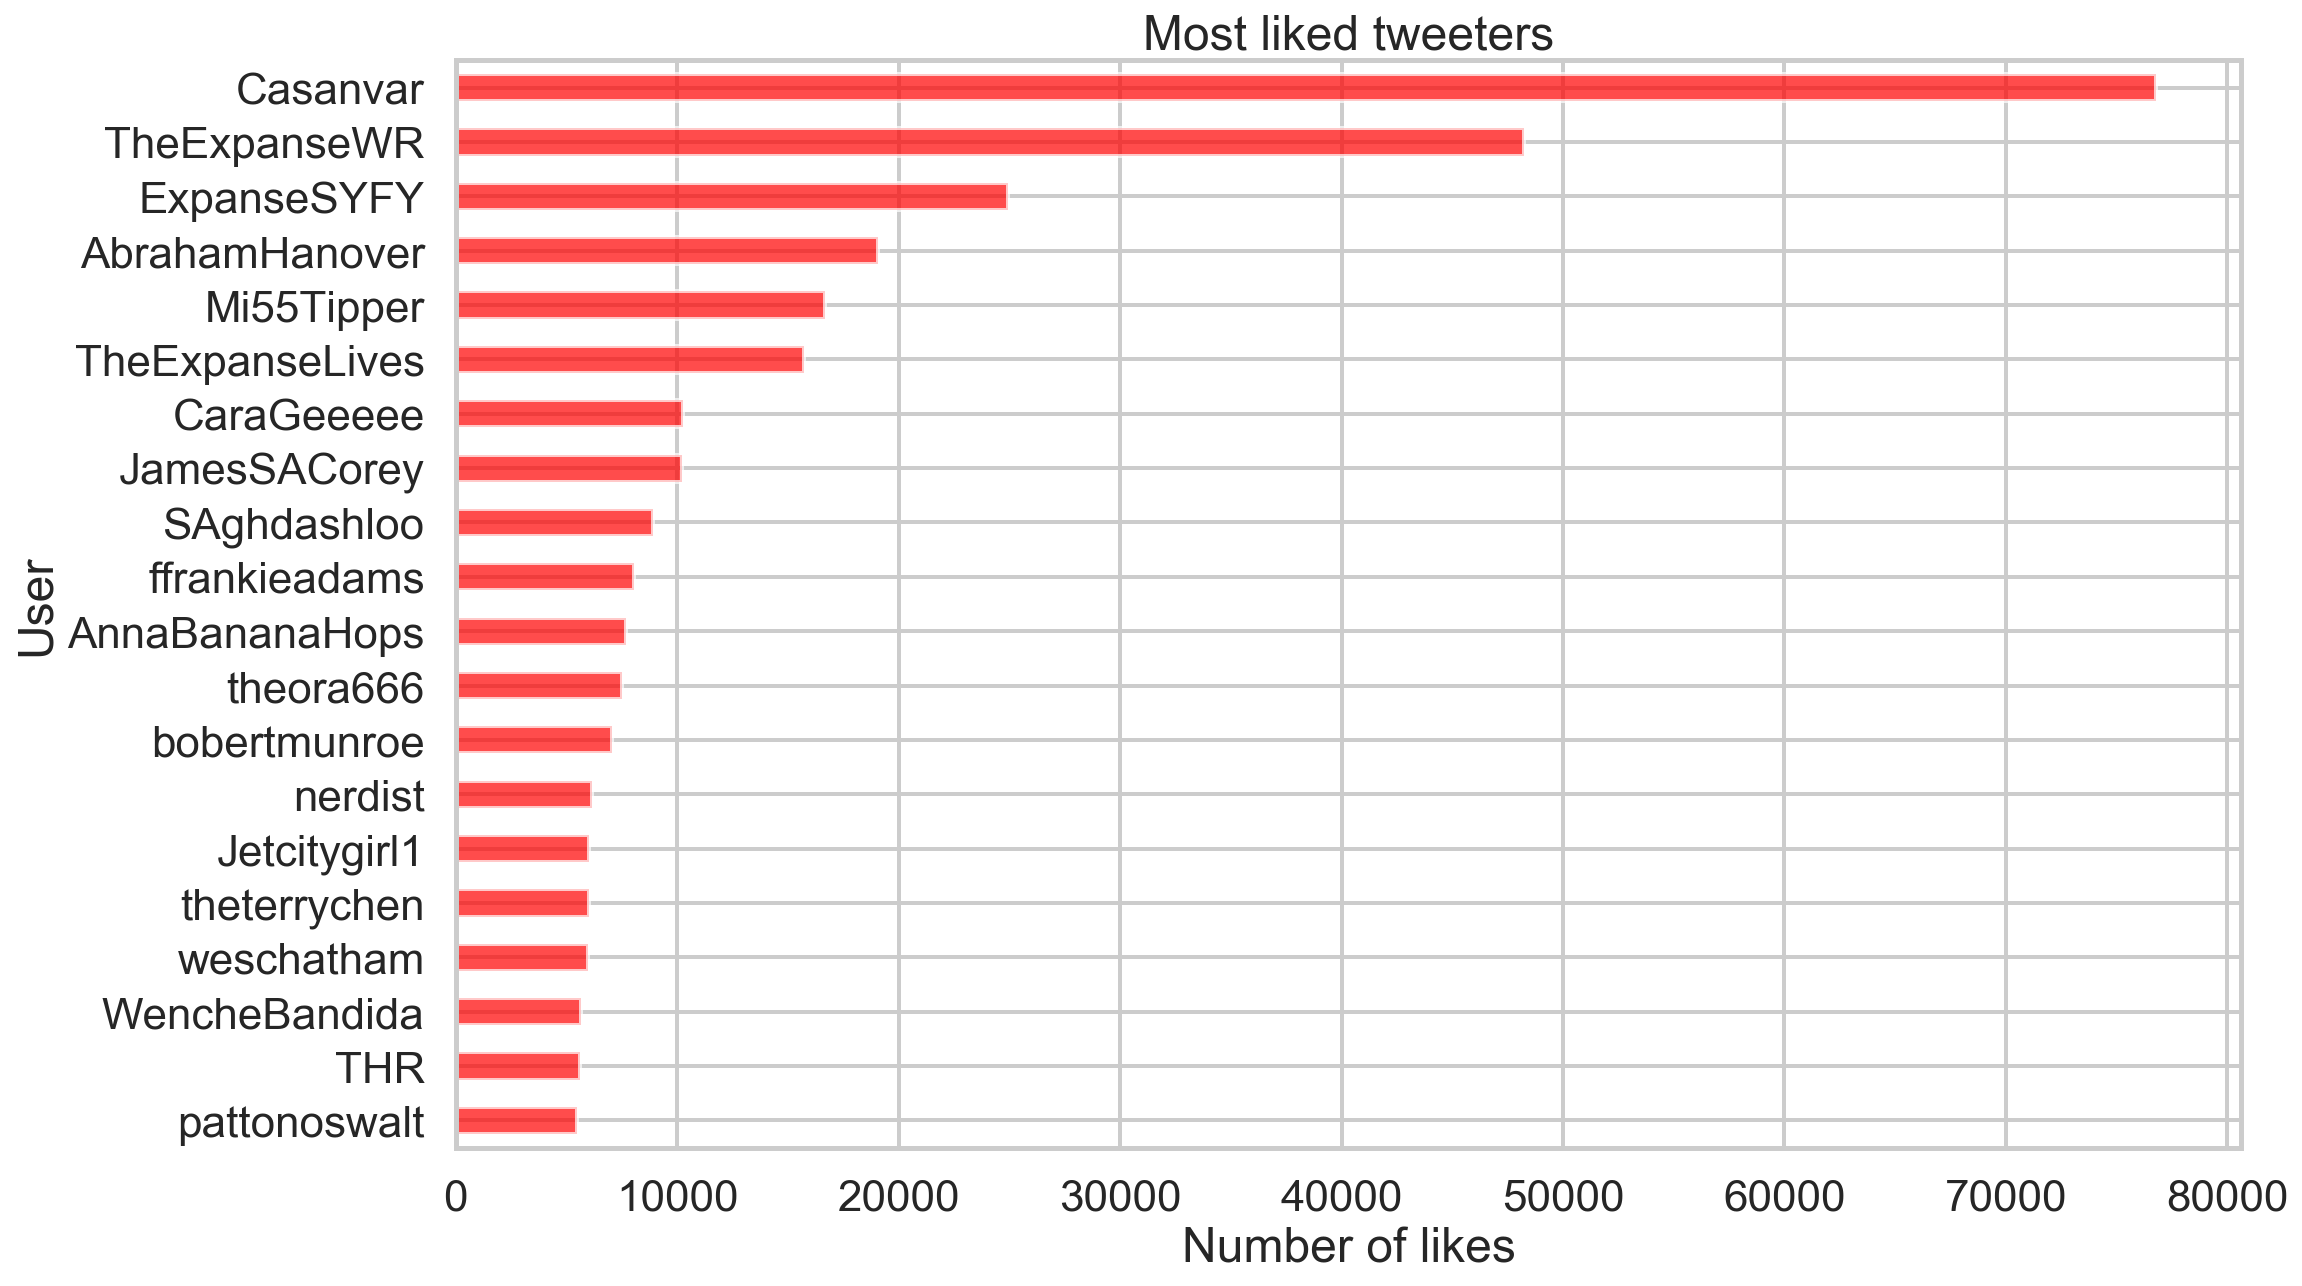

In [70]:
most_influential = df.groupby('user')['likes'].sum().sort_values().tail(20)
ax = most_influential.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16, 10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of likes')
ax.set_title('Most liked tweeters')

# Most influential (retweets per tweet)

Text(0.5,1,'Most influential tweeters (normalized)')

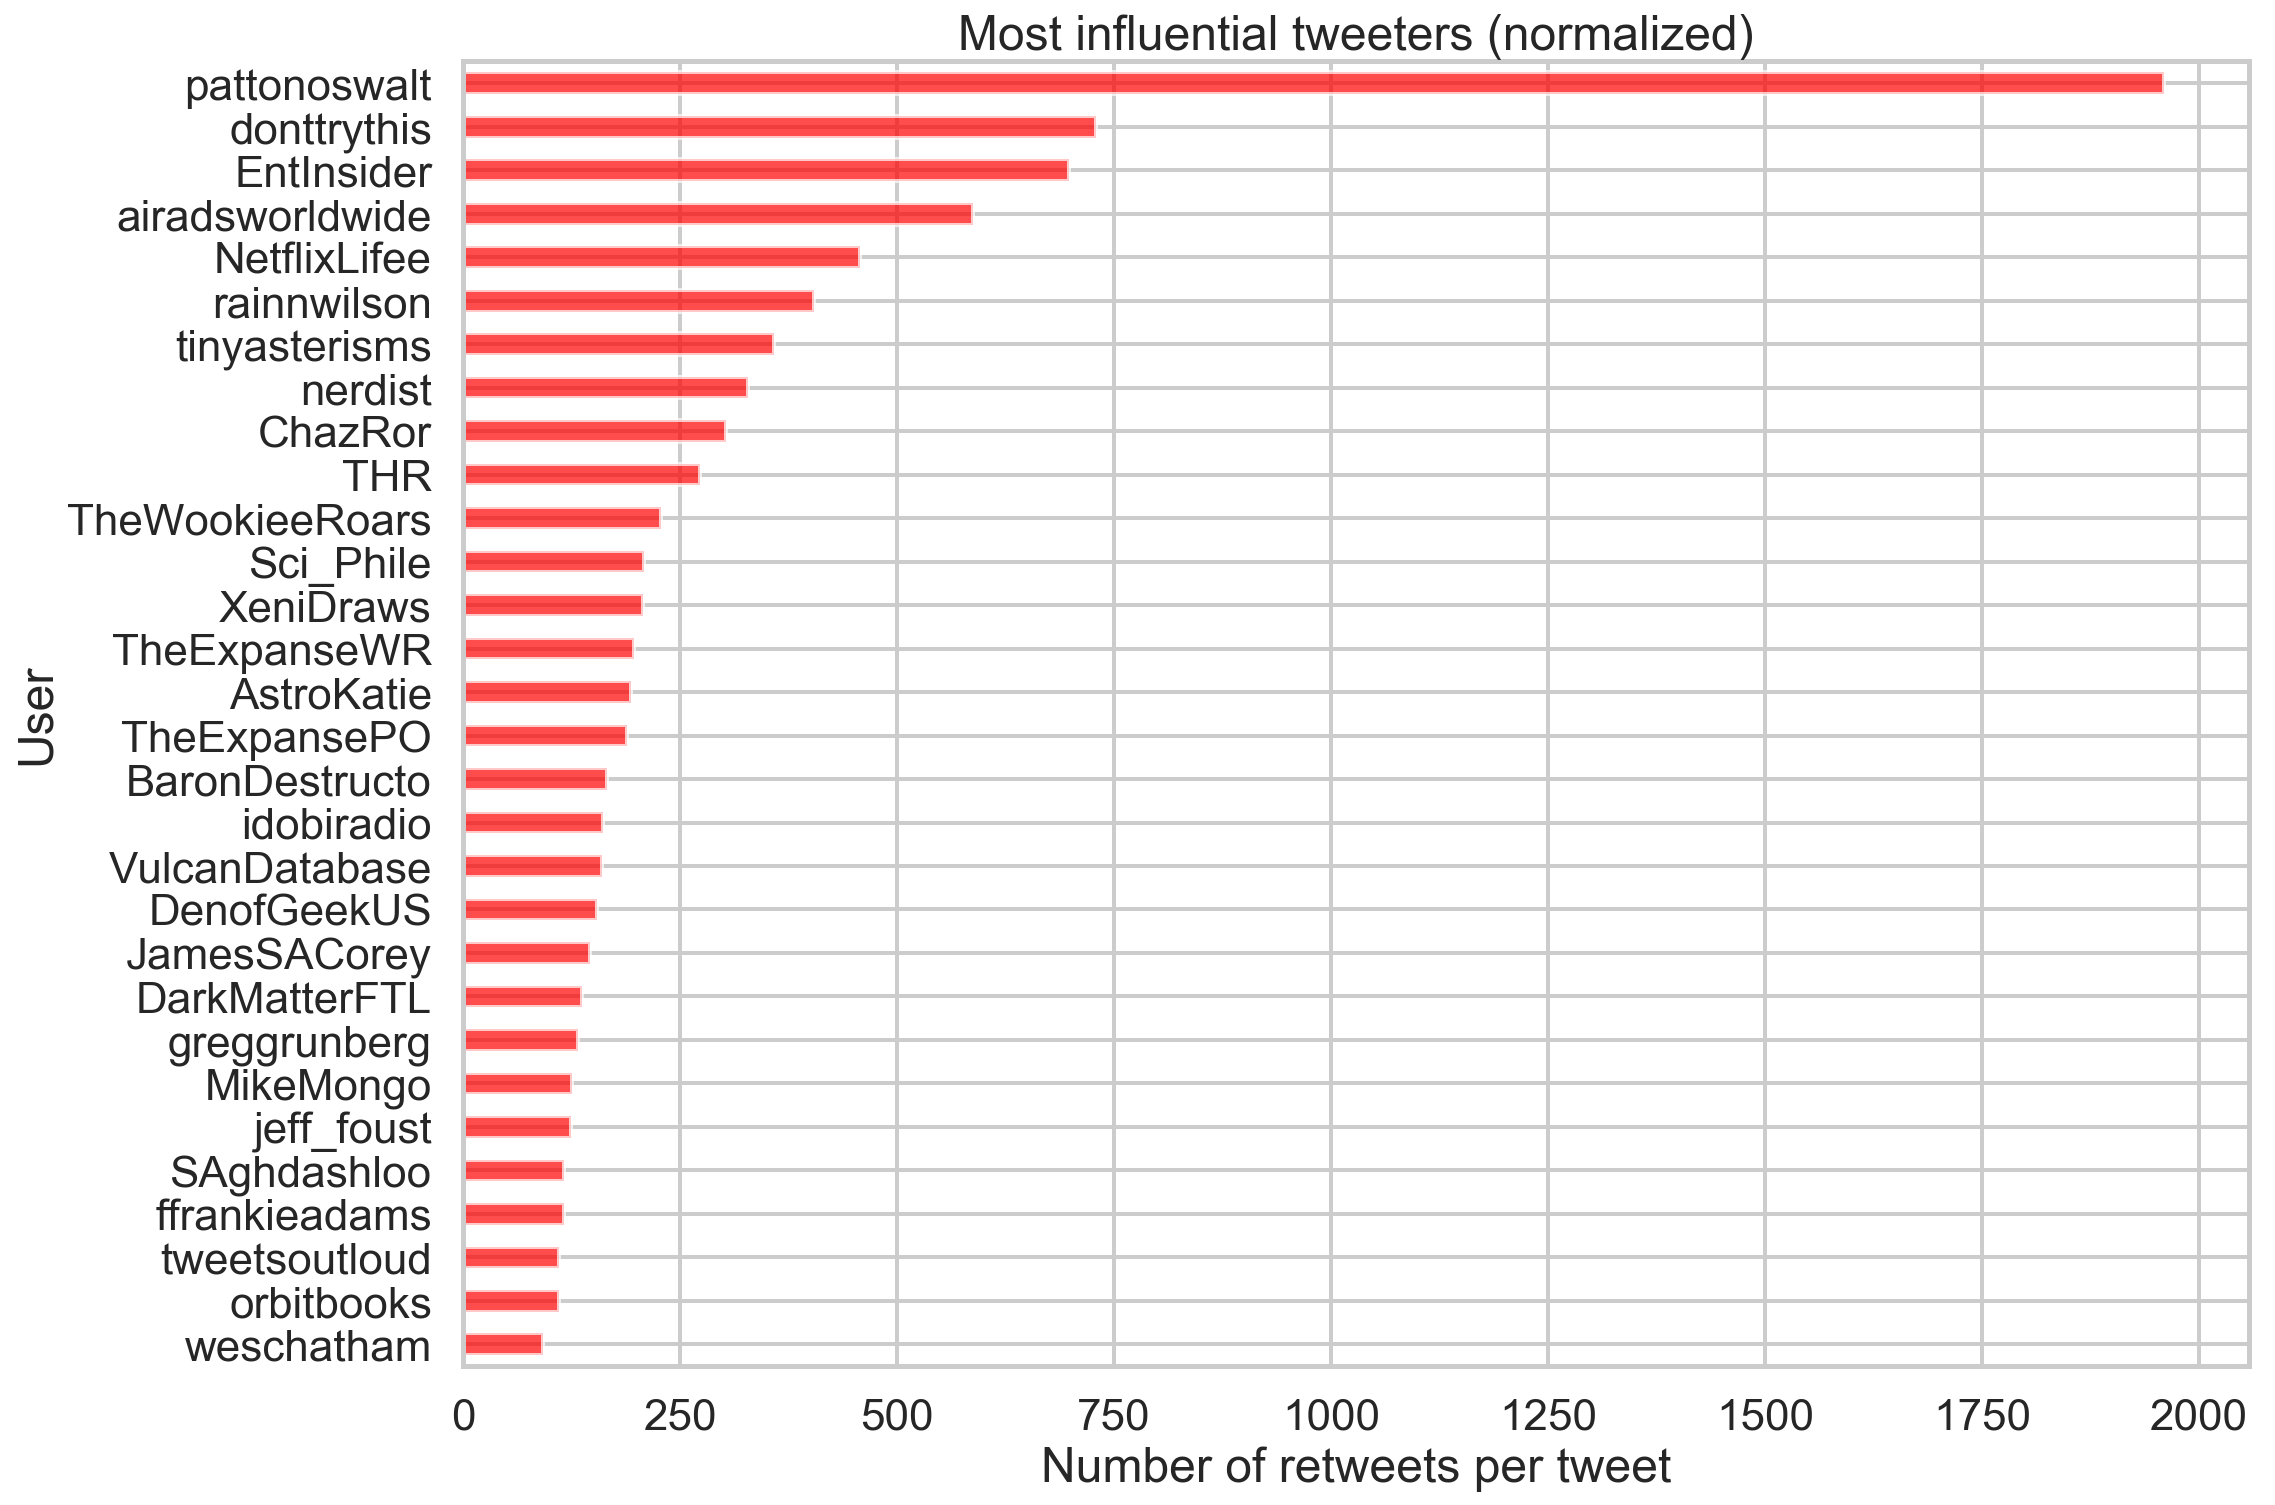

In [71]:
most_influential = df.groupby('user')['retweets'].sum().sort_values()
num_tweets_per_user = df['user'].value_counts()
num_tweets_per_user.name = 'num_tweets'
merged = pd.concat([most_influential, num_tweets_per_user], axis='columns')
most_influential_norm = merged['retweets'] / merged['num_tweets']
most_influential_norm = most_influential_norm.sort_values().tail(30)

ax = most_influential_norm.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16,12),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of retweets per tweet')
ax.set_title('Most influential tweeters (normalized)')

# Engagement time series

Text(0.5,1,'"Save The Expanse" Engagement Over Time')

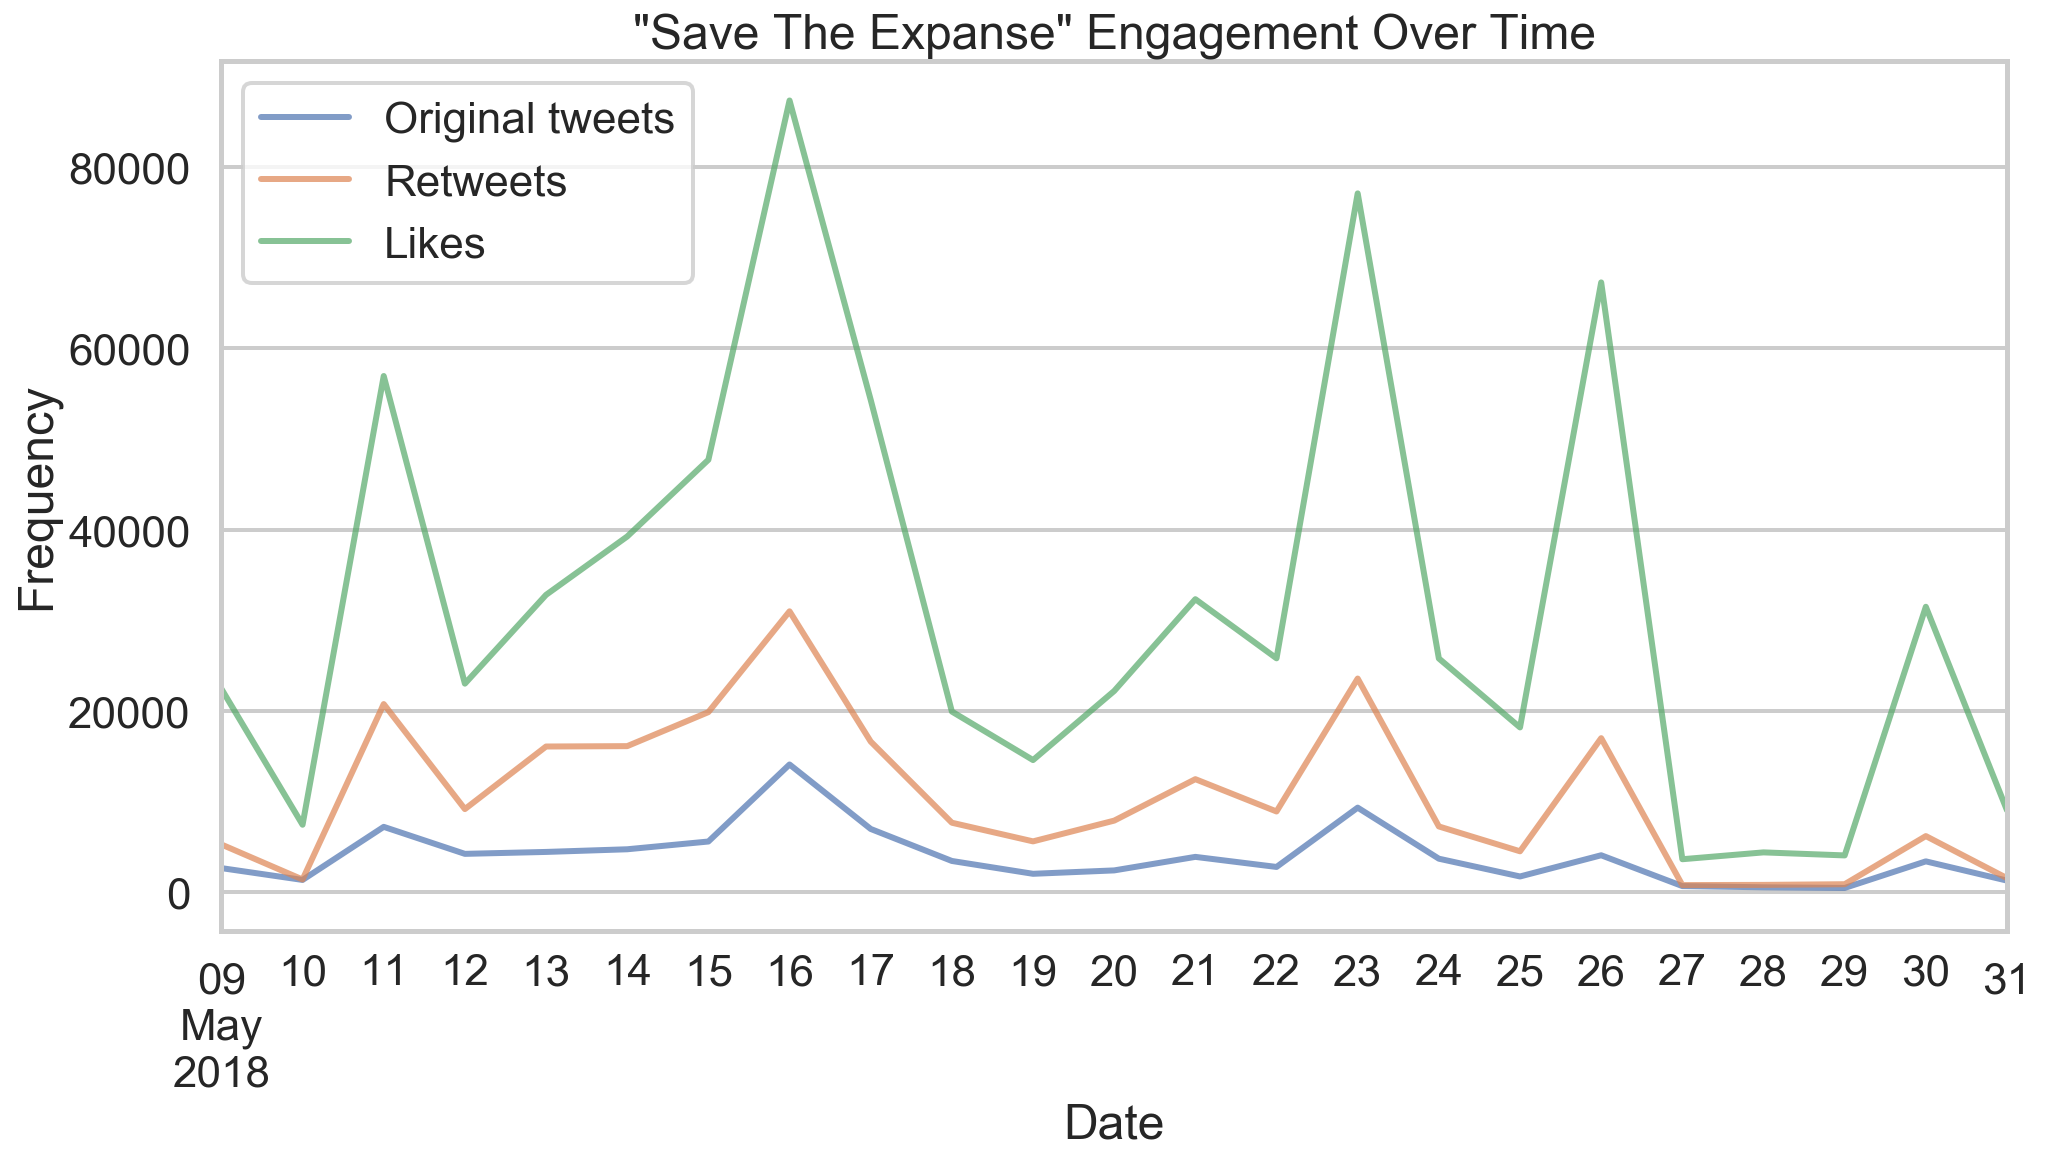

In [72]:
may_num_tweets = df.resample('d').size()
ax = may_num_tweets.plot.line(
    alpha=0.7,
    figsize=(16,8),
    label='Original tweets'
)

for feature in ['retweets', 'likes']:
    may_feature = df.resample('d')[feature].sum()
    may_feature.plot.line(
        ax=ax,
        alpha=0.7,
        label=feature.capitalize()
    )

ax.legend()
ax.set_xlim(17660, 17682)
ax.set_ylabel('Frequency')
ax.set_xlabel('Date')
ax.set_title('"Save The Expanse" Engagement Over Time')

# Hashtags

In [73]:
hashtags = list()
dates = list()
for timestamp, row in df.iterrows():
    matches = re.findall(r'#[a-z|\d]*', row['text'].lower())
    hashtags.extend(matches)
    dates.extend([timestamp.date()] * len(matches))
    
hashtags = pd.Series(hashtags, index=dates)

[Text(0,0.5,'Hashtag'),
 Text(0.5,0,'Frequency of use in original tweets'),
 Text(0.5,1,'Most popular hashtags')]

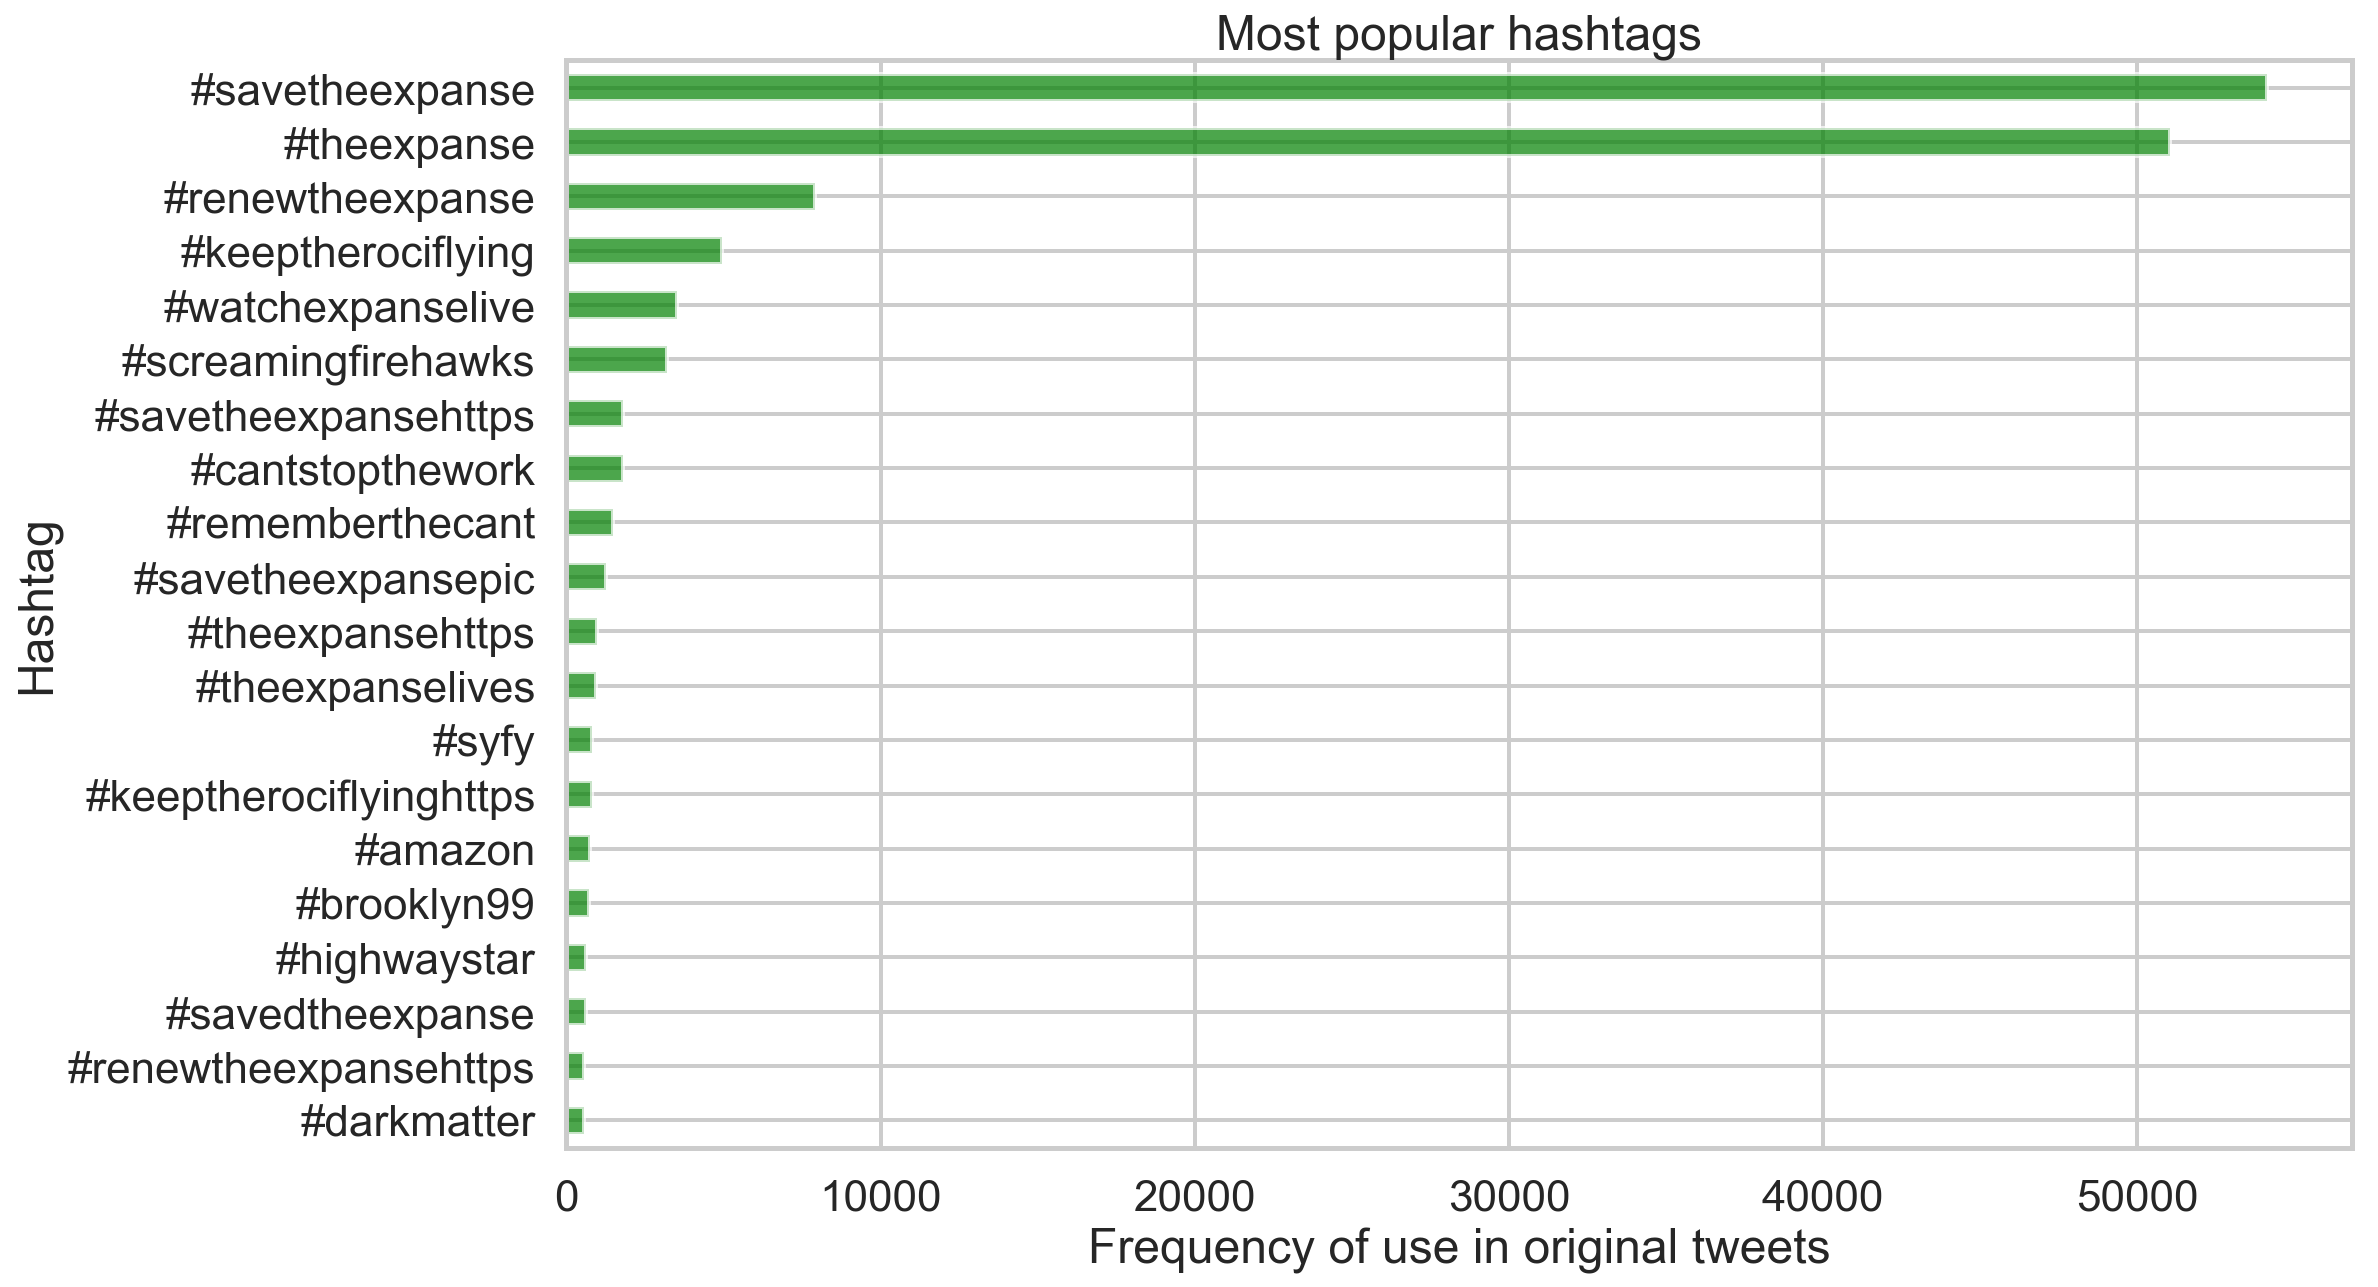

In [74]:
hashtag_counts = hashtags.value_counts().head(20)
hashtag_counts = secondary_hashtags.sort_values(ascending=True)
ax = hashtag_counts.plot.barh(
    figsize=(16,10),
    color='green',
    alpha=0.7,
)

ax.set(
    title='Most popular hashtags',
    xlabel='Frequency of use in original tweets',
    ylabel='Hashtag'
)

[Text(0,0.5,'Frequency in original tweets'),
 Text(0.5,1,'Most popular hashtags')]

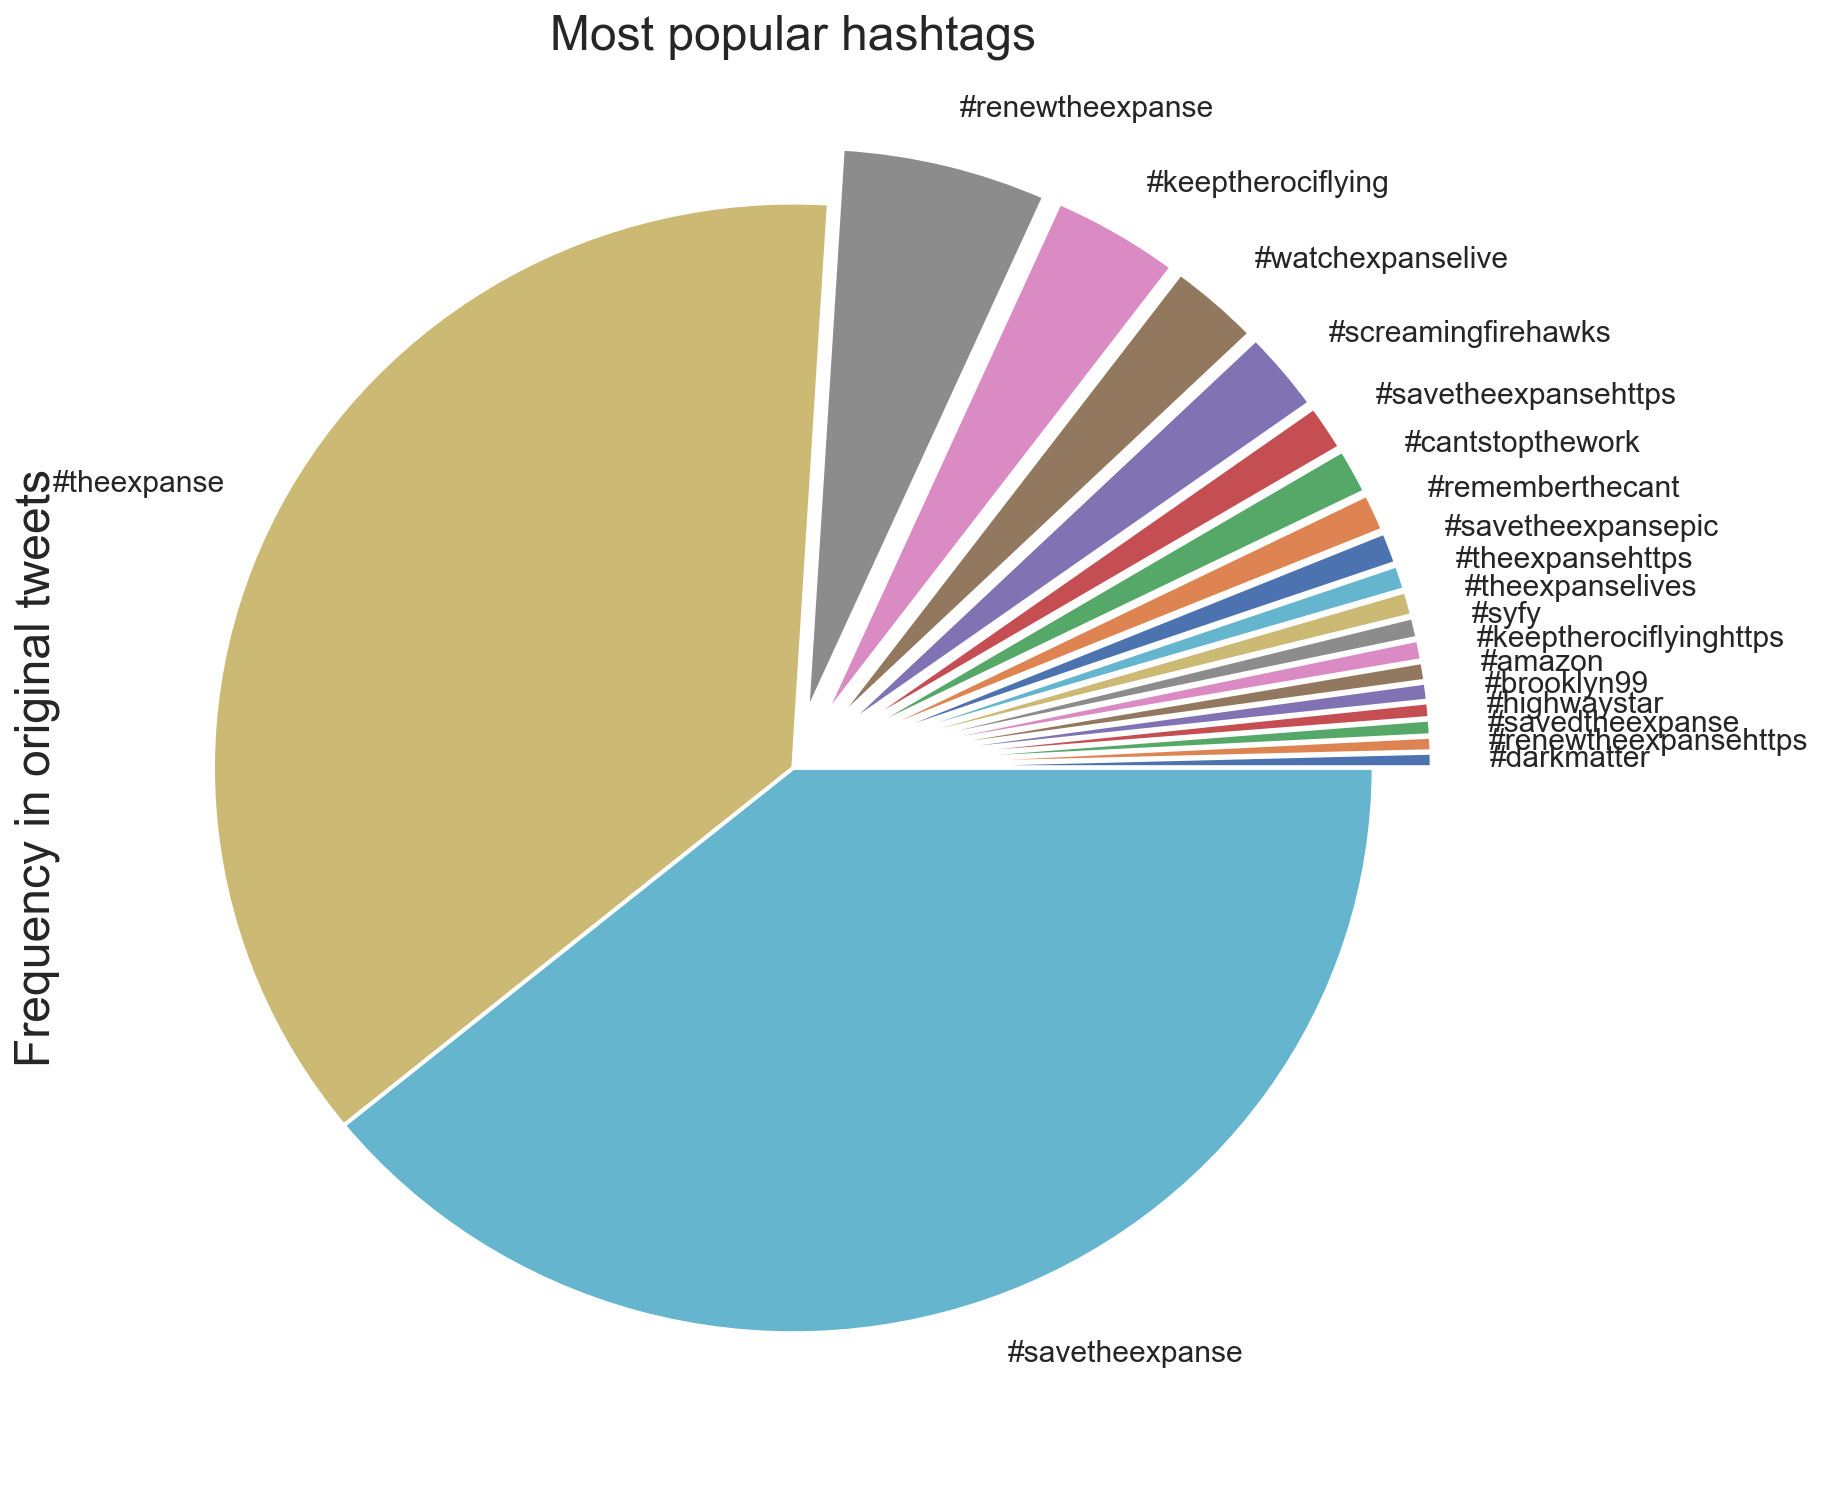

In [75]:
ax = hashtag_counts.plot.pie(
    figsize=(13,13),
    explode=[0.1]*18 + [0]*2,
    fontsize=15,
)

ax.set(
    title='Most popular hashtags',
    ylabel='Frequency in original tweets'
)

# Hashtags time series

[Text(0,0.5,'Frequency in original tweets'),
 Text(0.5,0,'Date'),
 Text(0.5,1,'Most popular hashtags')]

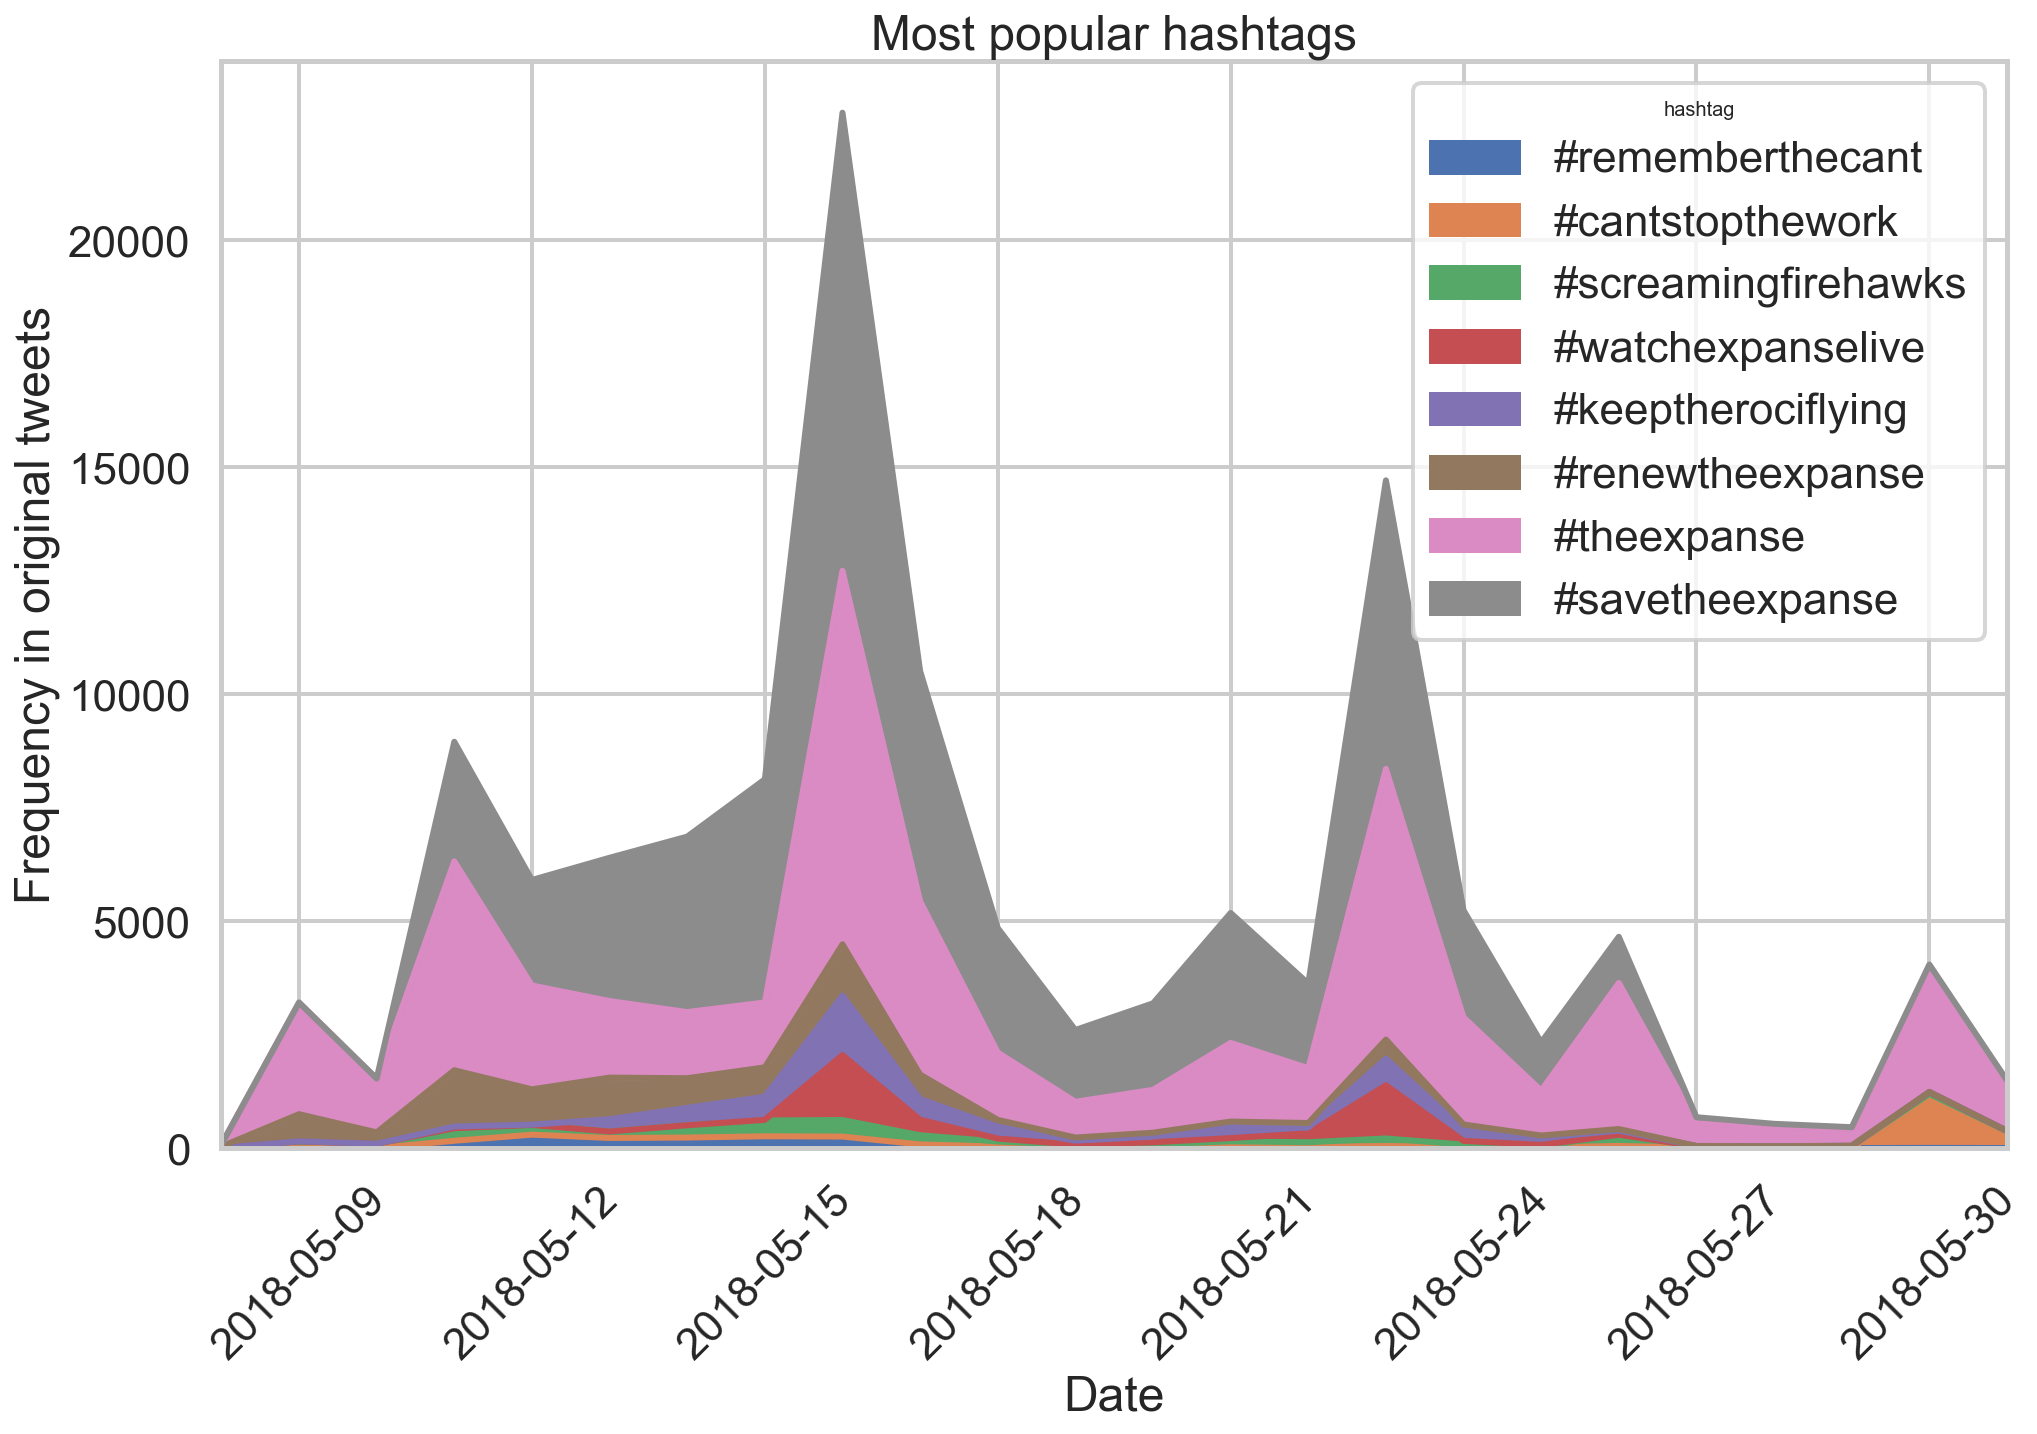

In [76]:
relevant_hashtags = [
    '#theexpanse',
    '#savetheexpanse',
    '#renewtheexpanse',
    '#keeptherociflying',
    '#cantstopthework',
    '#rememberthecant',
    '#watchexpanselive',
    '#screamingfirehawks',
]

hashtags_df = hashtags.reset_index()
hashtags_df.columns = ['date', 'hashtag']
hashtags_df = hashtags_df[hashtags_df['hashtag'].isin(relevant_hashtags)]
hashtags_df = hashtags_df.groupby(['date', 'hashtag']).size()
hashtags_df = hashtags_df.unstack('hashtag')
hashtags_df = hashtags_df.fillna(0)

order = hashtags_df.sum().sort_values(ascending=True).index
hashtags_df = hashtags_df[order]

ax = hashtags_df.plot.area(
    figsize=(16, 10),
    stacked=True,
    sort_columns=False,
    rot=45,
)

ax.set(
    title='Most popular hashtags',
    xlabel='Date',
    ylabel='Frequency in original tweets',
)

[Text(0,0.5,'Frequency in original tweets'),
 Text(0.5,0,'Date'),
 Text(0.5,1,'Most popular hashtags')]

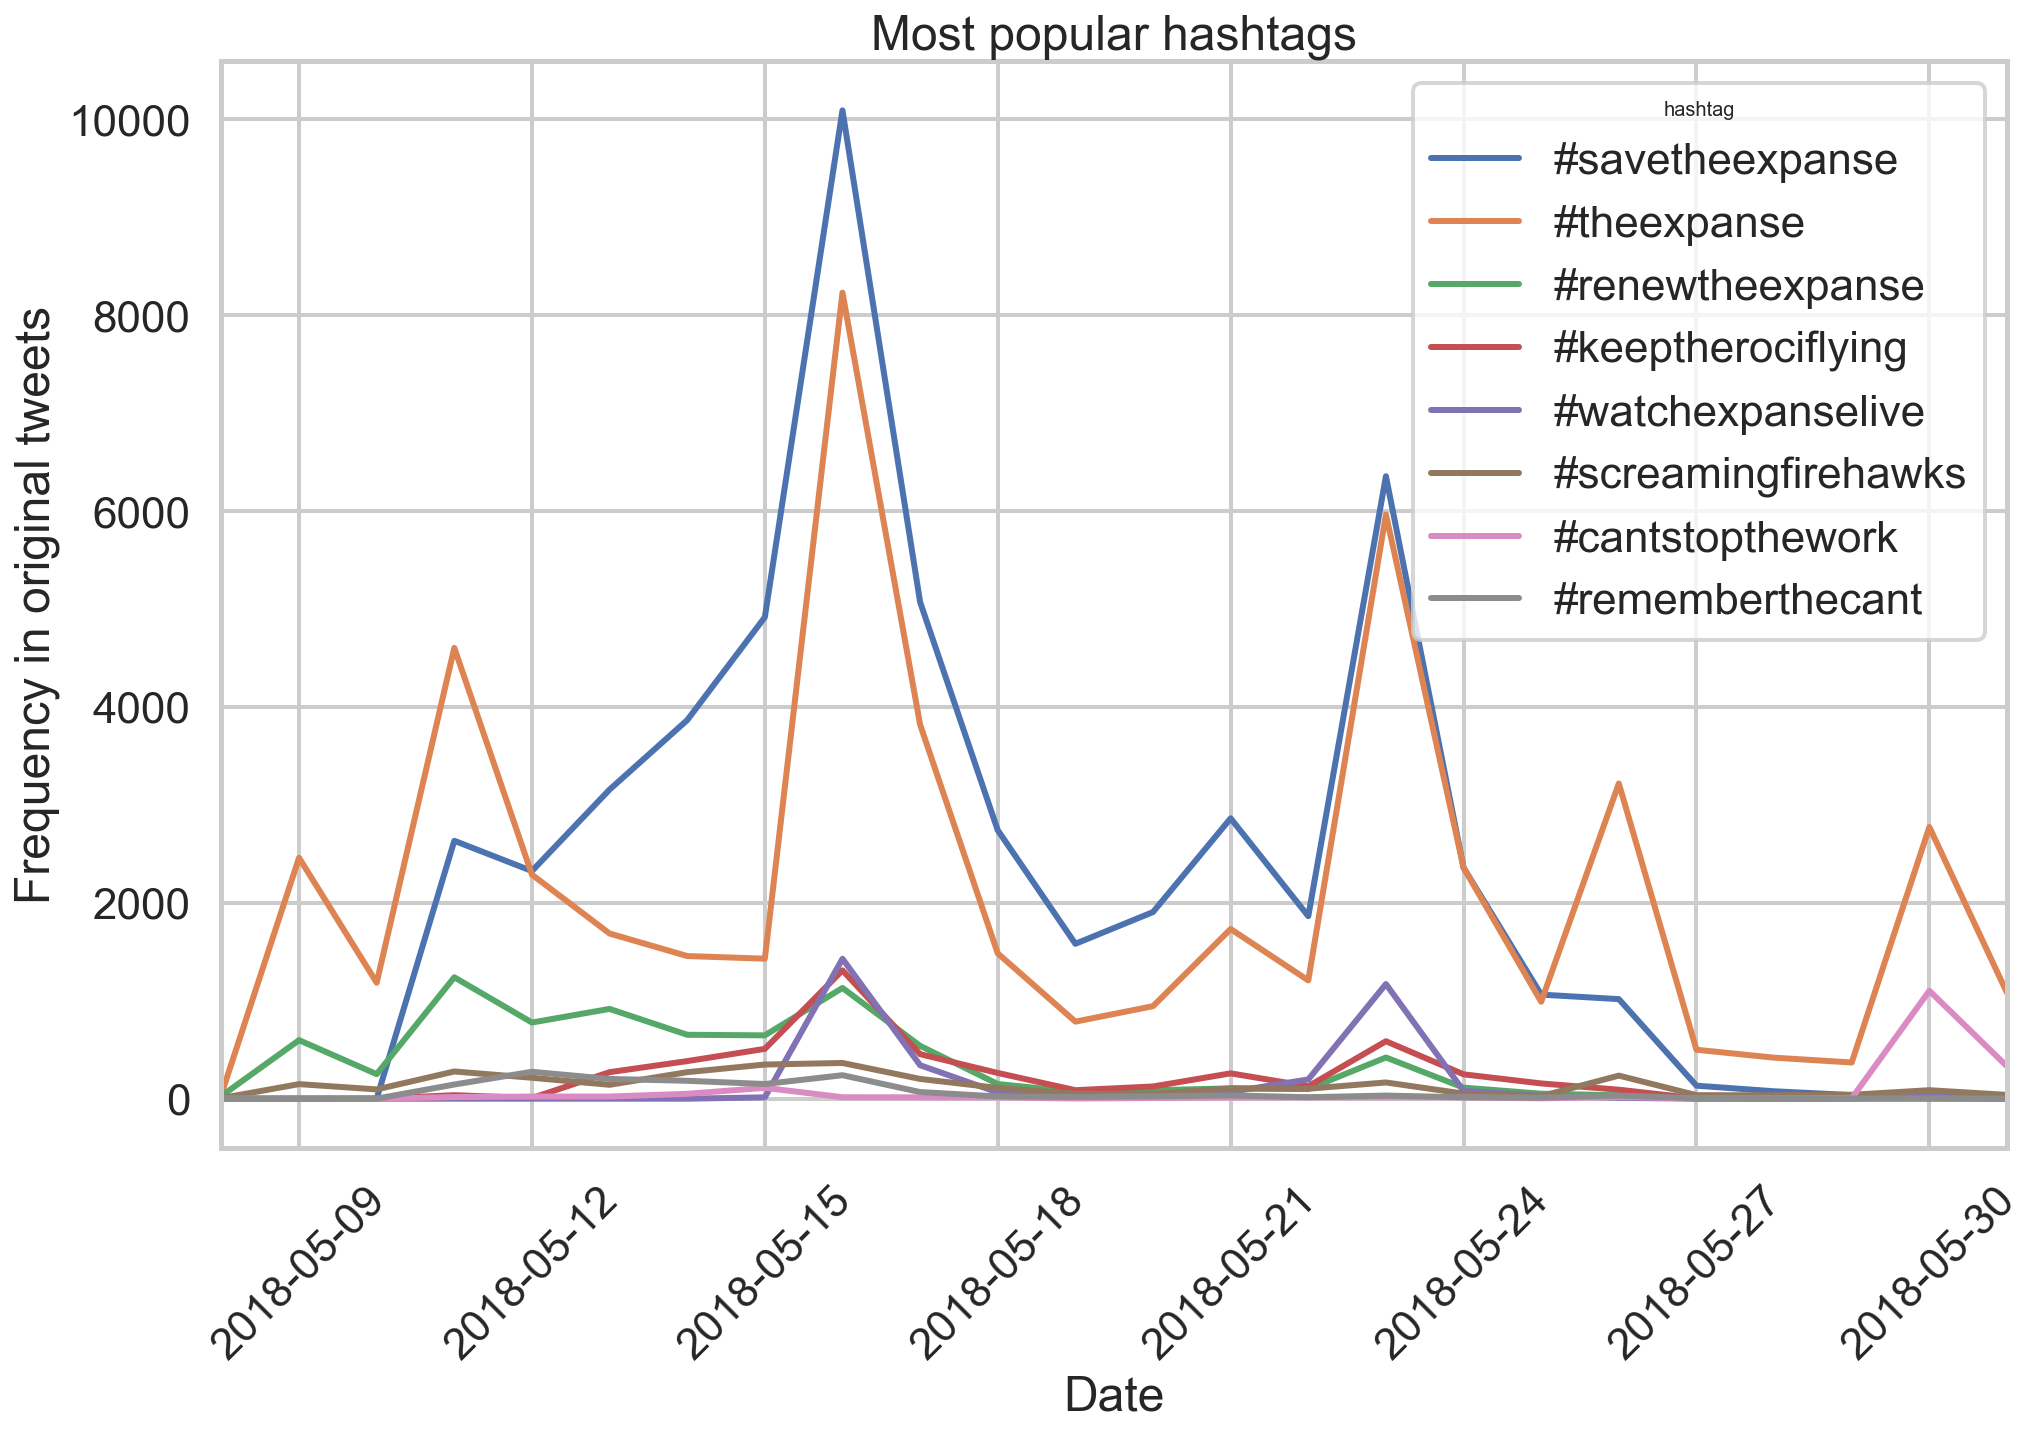

In [77]:
hashtags_df = hashtags_df[list(reversed(order))]
ax = hashtags_df.plot.line(
    figsize=(16, 10),
    sort_columns=False,
    rot=45,
)

ax.set(
    title='Most popular hashtags',
    xlabel='Date',
    ylabel='Frequency in original tweets',
)

# Mentions

In [78]:
mentions = list()
dates = list()
for timestamp, row in df.iterrows():
    matches = re.findall(r'@[a-z|\d]*', row['text'].lower())
    mentions.extend(matches)
    dates.extend([timestamp.date()] * len(matches))
    
mentions = pd.Series(mentions, index=dates)

[Text(0,0.5,'Mention'),
 Text(0.5,0,'Frequency of use in original tweets'),
 Text(0.5,1,'Most popular mentions')]

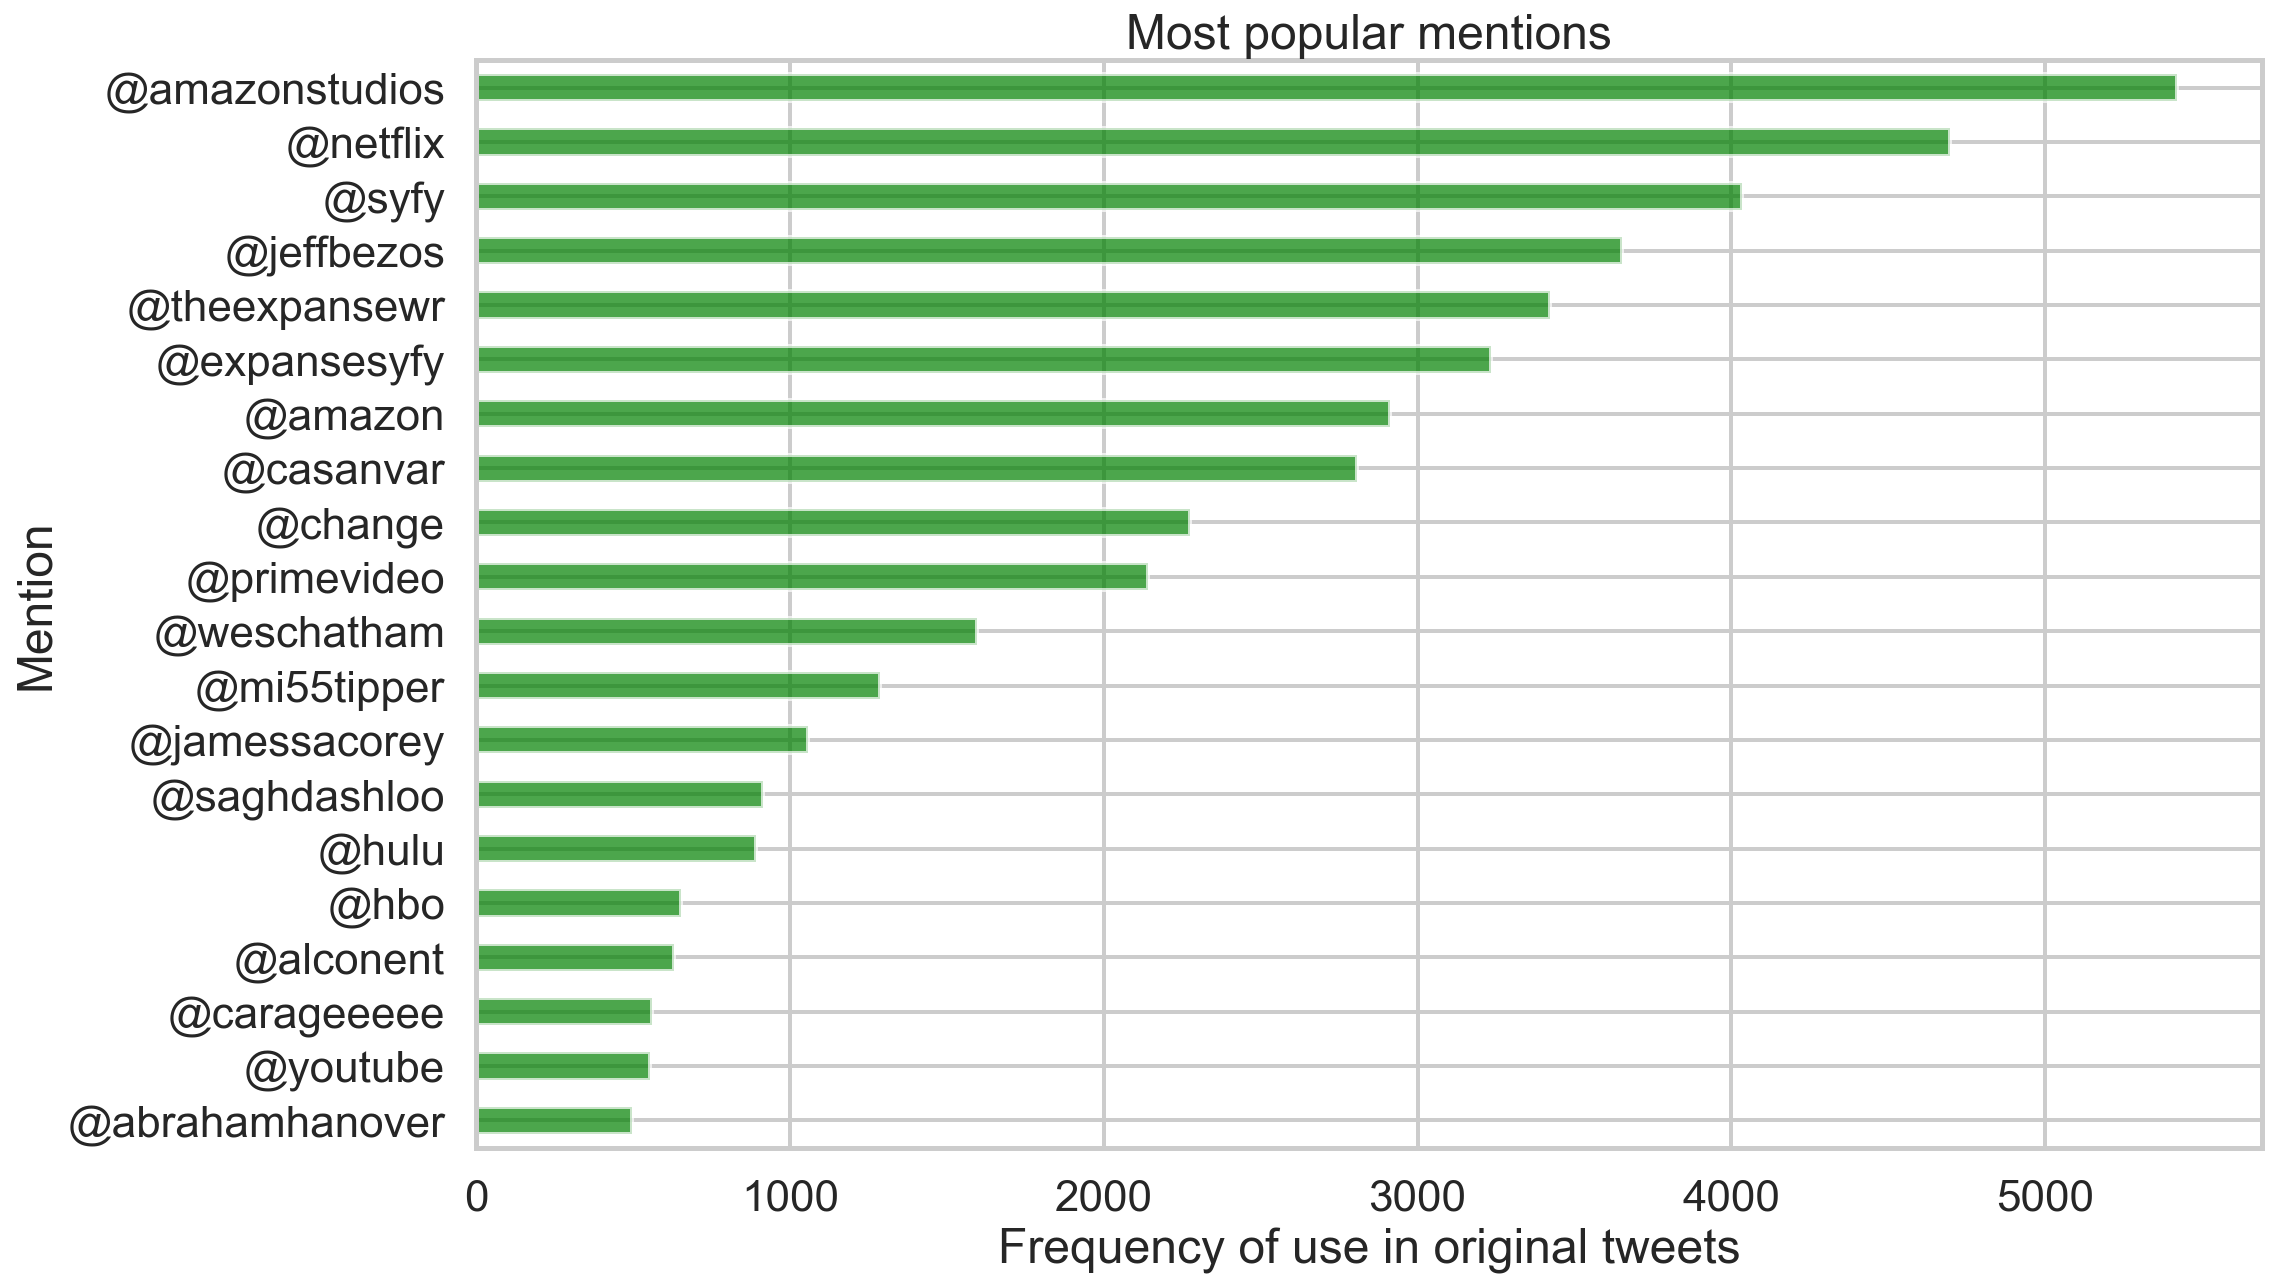

In [79]:
mention_counts = mentions.value_counts()[0:20]
mention_counts = mention_counts.sort_values(ascending=True)
ax = mention_counts.plot.barh(
    figsize=(16,10),
    color='green',
    alpha=0.7,
)

ax.set(
    title='Most popular mentions',
    xlabel='Frequency of use in original tweets',
    ylabel='Mention'
)

# Mention time series 

[Text(0,0.5,'Frequency in original tweets'),
 Text(0.5,0,'Date'),
 Text(0.5,1,'Most popular mentions')]

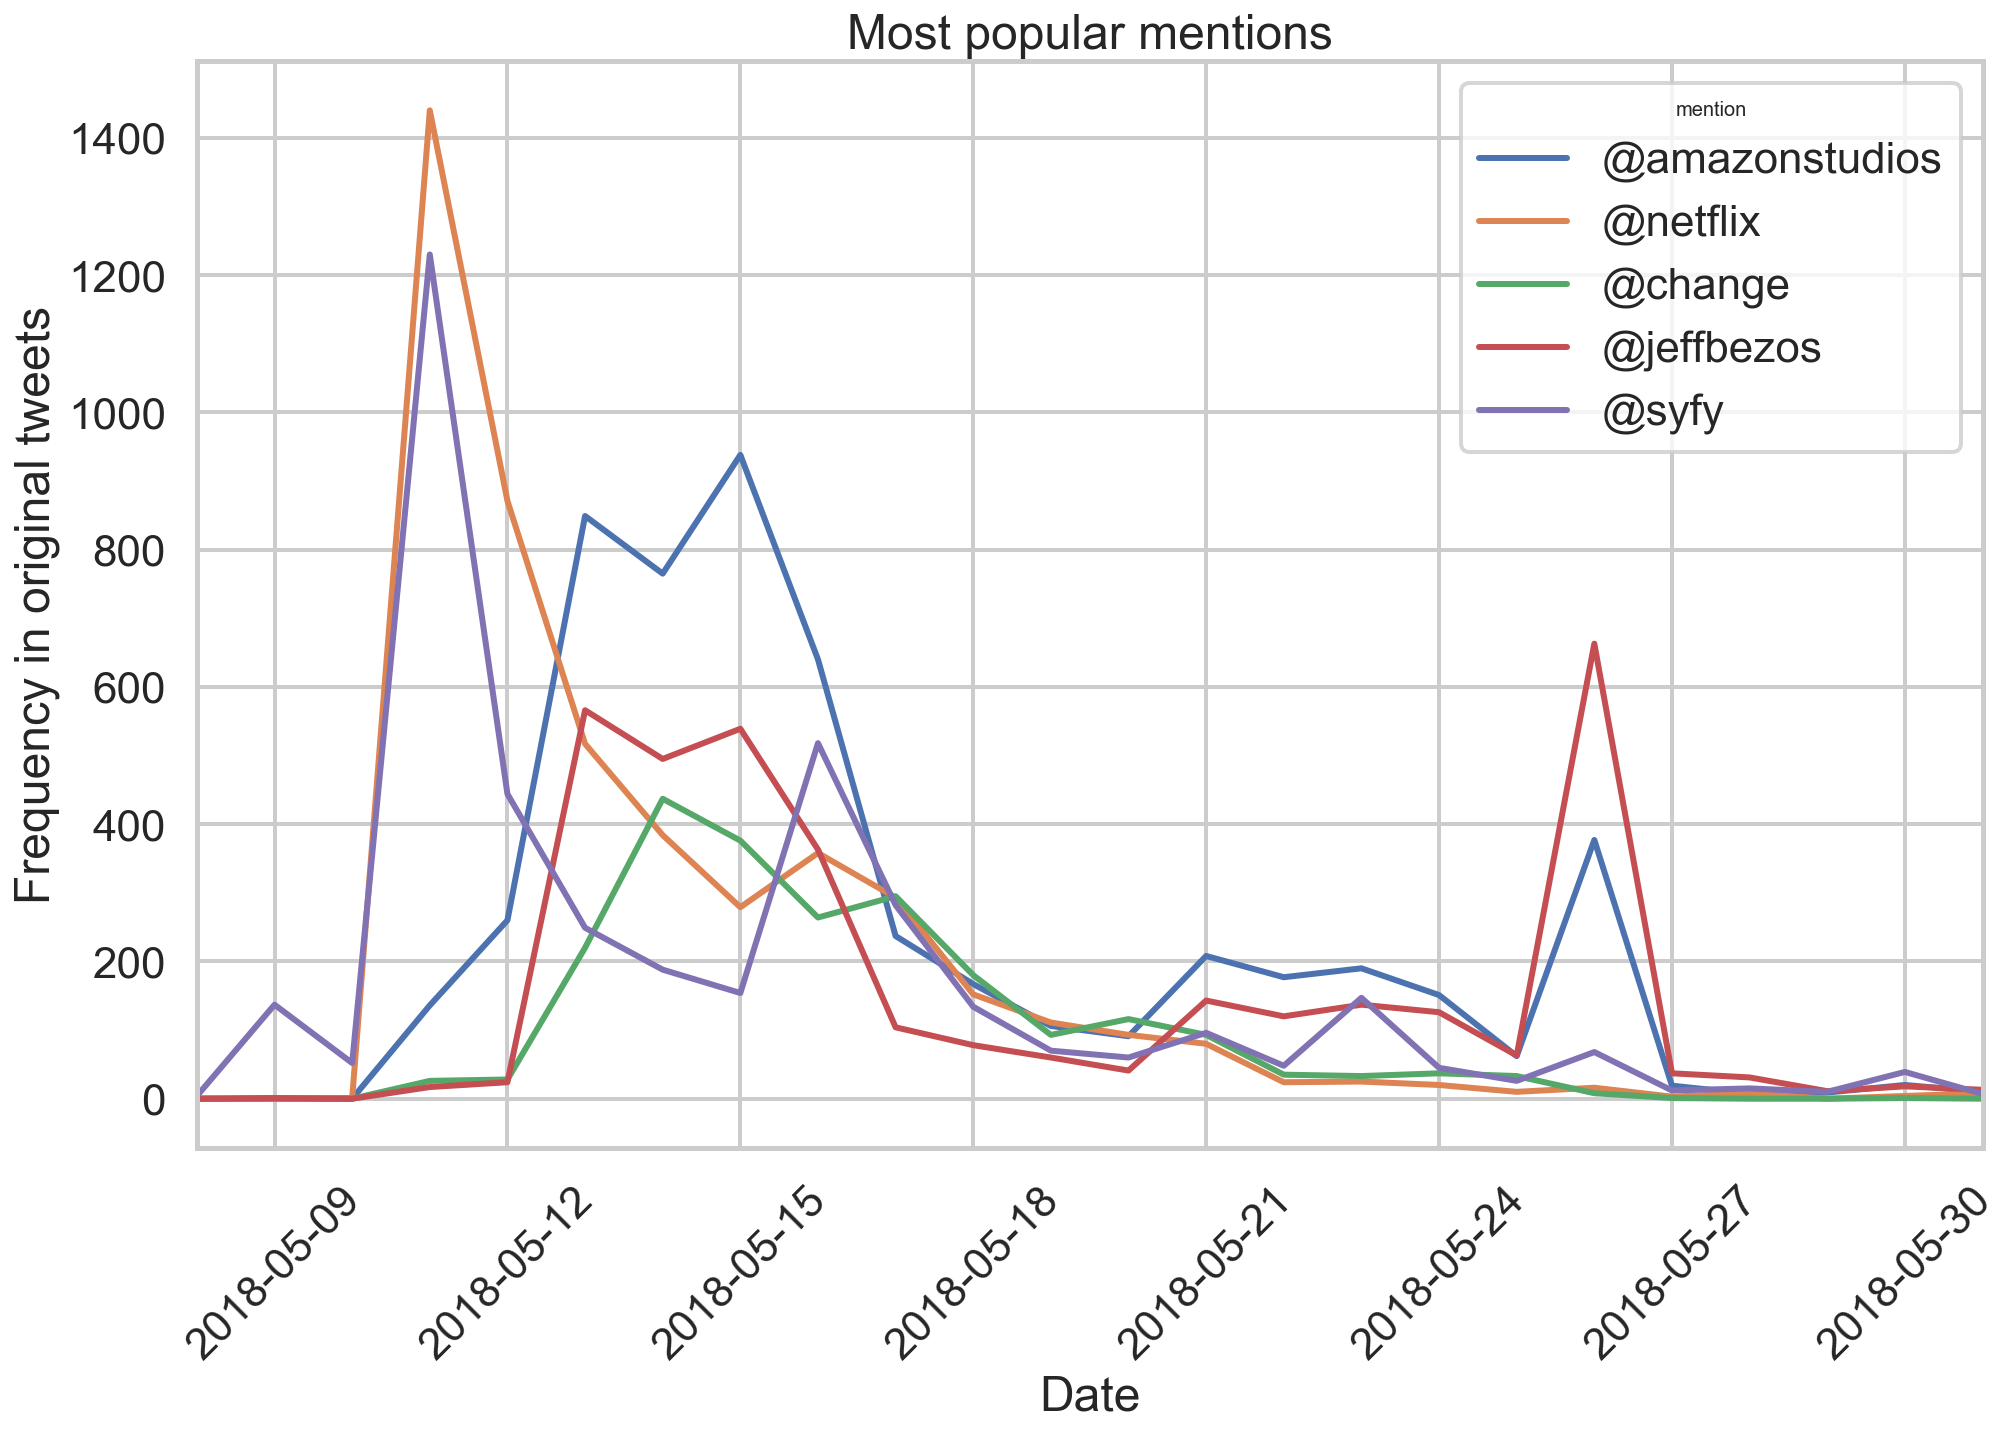

In [80]:
mentions_df = mentions.reset_index()
mentions_df.columns = ['date', 'mention']
mentions_df = mentions_df[mentions_df['mention'].isin(mention_counts.index[-10:])]
mentions_df = mentions_df.groupby(['date', 'mention']).size()
mentions_df = mentions_df.unstack('mention')
mentions_df = mentions_df.fillna(0)

order = [
    '@amazonstudios',
    '@netflix',
    '@change',
    '@jeffbezos',
    '@syfy',
]

mentions_df = mentions_df[order]
ax = mentions_df.plot.line(
    figsize=(16, 10),
    sort_columns=False,
    rot=45,
)

ax.set(
    title='Most popular mentions',
    xlabel='Date',
    ylabel='Frequency in original tweets',
)

# Word cloud

In [81]:
# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [82]:
tokens = list()

from nltk.corpus import stopwords
stopwords = list(stopwords.words('english'))
stopwords.extend(['…', '-'])

for tweet in df['text'].str.lower():
    tweet_tokens = tweet.split()
    for token in tweet_tokens:
        if token.startswith(('#', '@')):
            continue
        if '.com' in token or 'http' in token or ('.' in token and '/' in token):
            continue
        token = re.sub(r'#|@|!|\.|"|\?|&|\*|\(|\)|,', ' ', token)
        token = token.strip()
        if token in stopwords:
            continue
        if token:
            tokens.append(token)
            
tokens = pd.Series(tokens)
tokens = tokens.value_counts()

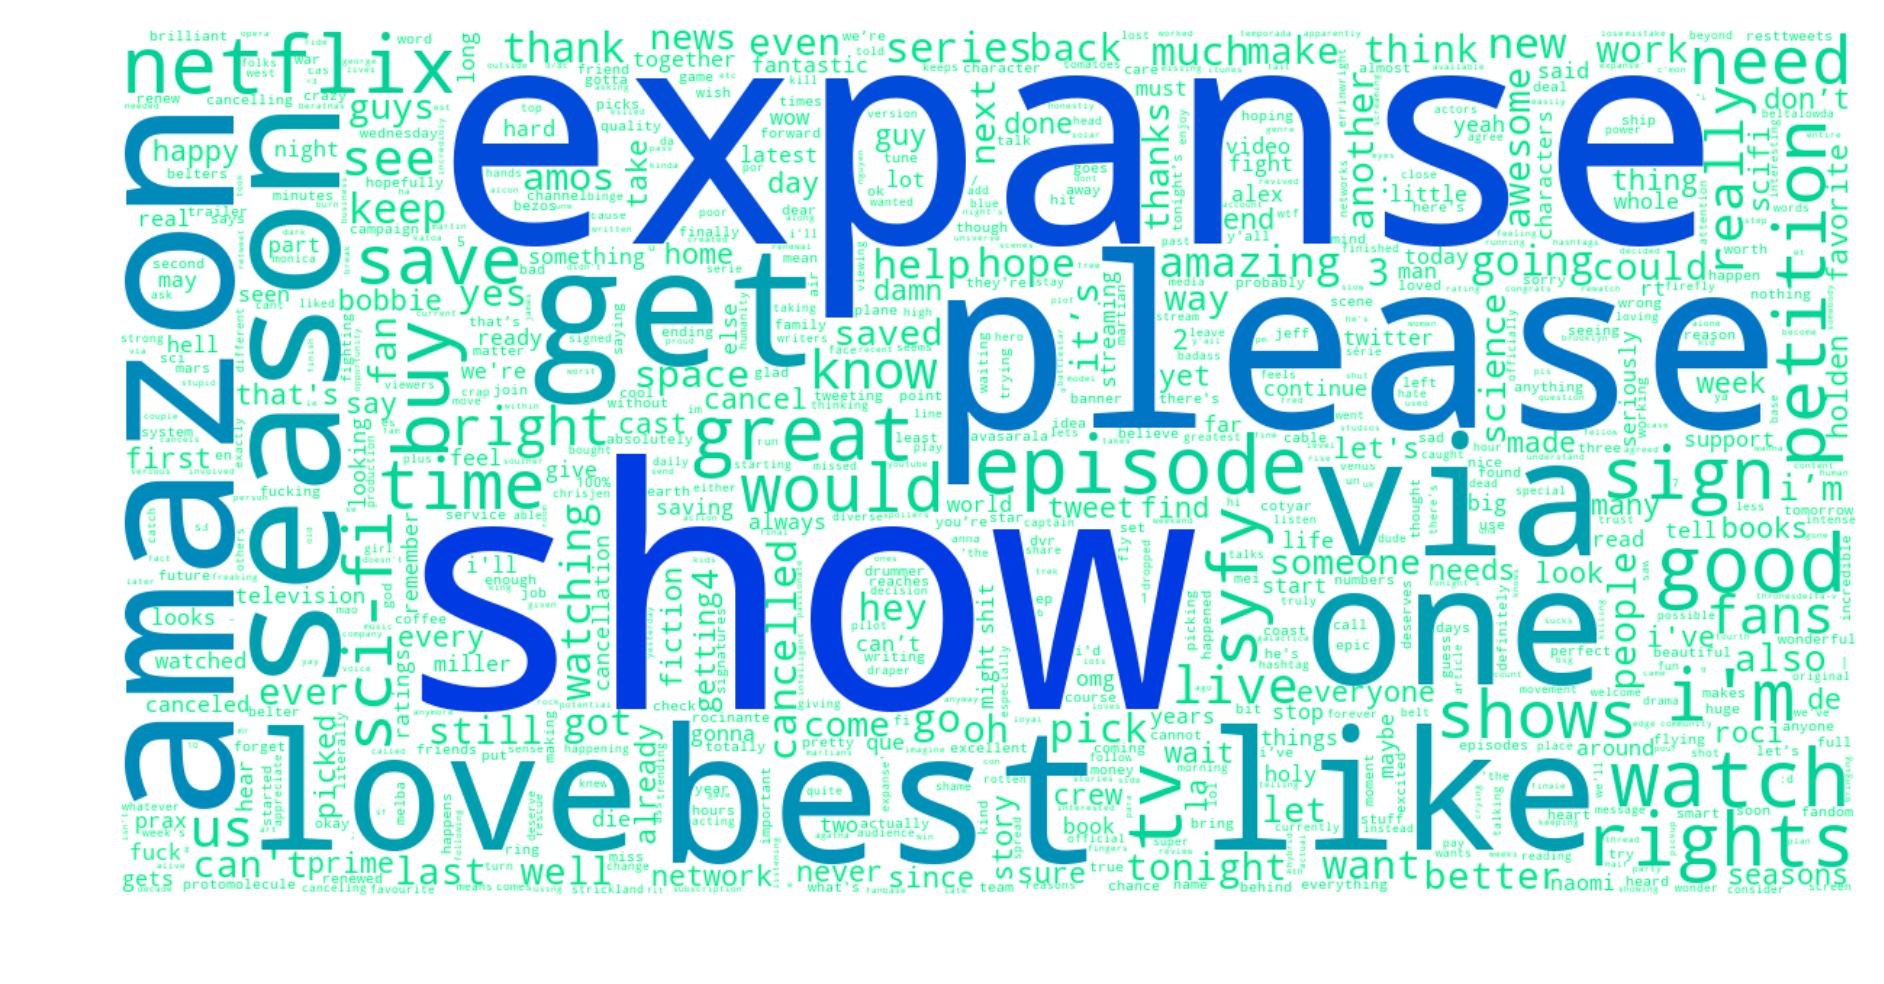

In [83]:
# make word cloud
word_freq_dict = dict(tokens)
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('winter_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');